# Super Resolution Generative Adversarial Network (SRGAN) of CelebA Dataset

## Introduction

This program will train a model to generate realistic high-resolution (HR) images from low-resolution (LR) images. Alternatively, you can skip the training and go straight to generation by loading the pre-trained model included in the repository.

To train the model yourself:
1. Download the dataset from [here.](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ)
2. Extract the images to `SRGAN/datasets/img_align_celeba/<000001.jpg,  000002.jpg,  etc.>`
3. Run all cells in the `Training` section.  (Note: on a Nvidia RTX 2080 Super GPU, training took ~15 hours for 30000 epochs.)

To generate HR images from LR images:
1. Run the cell in the `Loading a Model` section.
2. Run all cells in the `Generation` section.
3. To try generating your own images, move a .jpg file it into the same directory as this notebook and adjust the filepath in the `rescale_img` examples.

In [ ]:
import pickle

pickle.dump(g_loss_list1, open('G1_A0001_B9.pkl', 'wb'))
pickle.dump(g_loss_list2, open('G2_A0001_B9.pkl', 'wb'))
pickle.dump(g_loss_list3, open('G3_A0001_B9.pkl', 'wb'))

## Training

In [1]:
#from __future__ import print_function, division

#from keras.datasets import mnist
import tensorflow as tf
import keras.backend as K
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam

import datetime
import scipy
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
import cv2
import imageio
import regex as re

Using TensorFlow backend.


In [2]:
# Define the SRGAN class and methods.

class SRGAN():
    def __init__(self, load_weights=False):
        """
        Class initialization.
        
        ==Input==
          self object.
        
        ==Output==
          Instantiates self parameters and builds vgg, generator, discrimator, and combined models.
        """
        
        # Input shape of images
        self.channels = 3                        # (H, W, RGB)
        self.lr_height = 64                      # LR height
        self.lr_width = 64                       # LR width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = 256                     # HR height = LR height upscaled by factor of 4
        self.hr_width = 256                      # HR width = LR width upscaled by factor of 4
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)
        
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16
        
        optimizer = Adam(lr=0.0001)
        
        # Try to get epoch number of most recent checkpoint, if available
        try:
            filename = os.listdir('saved_model/')[1]
            regex = re.compile(r'\d+')            
            self.checkpoint_epoch_number = regex.findall(filename)[0]
        except:
            self.checkpoint_epoch_number = 0
        
        # Utilize a pre-trained VGG19 model to obtain perceptual content loss rather than pixel-wise loss.
        #    Specifically, the VGG19 model will extract image features from the original HR image and the
        #    generated HR image, and seek to minimize the mean-squared error between them.
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        
        # Utilize data_loader.py file to load in our dataset
        self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.hr_height, self.hr_width))
        
        # Calculate output shape of discriminator (PatchGAN). This is so penalizations will only occur occur
        #    in local image patches.
        patch = int(self.hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of generator and discriminator
        self.gf = 64
        self.df = 64

        # Build and compile the discriminator. See build_discriminator function for more details.
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy']) 
        
        # Build the generator. See build_generator function for more details.
        self.generator = self.build_generator()
        
        # Load model weighted from previous checkpoint, if desired.
        if load_weights:            
            print(f'Loading checkpoints from epoch {self.checkpoint_epoch_number}...')            
            self.generator.compile(loss='binary_crossentropy', optimizer=Adam())
            self.generator.load_weights(f'saved_model/generator{self.checkpoint_epoch_number}.h5')            
            self.discriminator.load_weights(f'saved_model/discriminator{self.checkpoint_epoch_number}.h5')
        
        # Define HR and LR image inputs.
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate HR image from LR image.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated image
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated HR images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)

        
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features based on the shape of our HR image.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model containing image features based on VGG19.
        """
        vgg = VGG19(weights="imagenet")
        # The goal here is to set the output of the pre-trained VGG19 model equal to the output of its
        #    third block, so that image features for 256 nodes are obtained (matching our HR image shape).
        #    See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)

        # Extract image features
        img_features = vgg(img)

        return Model(img, img_features)   
    
    
    def build_generator(self):
        """
        Builds the generator neural network.
        
        ==Input==
          self object.
        
        ==Output==
          Returns a Keras model including the input LR image, and a generated HR image.
        """

        def dense_block(layer_input, filters):
            """
            Defines the standard structure of the residual blocks.
            
            ==Input==
              layer_input: the network layer to process residuals from.
              filters: number of filters for Conv2D layers.
              
            ==Output==
              d: An element-wise sum of the entire block.
            """
            cx1 = layer_input
            
            d = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = cx2 = Add()([cx1, d])

            d = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = cx3 = Add()([cx1, cx2, d])

            d = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Add()([cx1, cx2, cx3, d])

            d = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(d)
            d = LeakyReLU(alpha=0.2)(d)
            d = Add()([cx1, cx2, cx3, d])

            d = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(d)
            d = Lambda(lambda d: d * 0.2)(d)
            d = Add()([cx1, d])            
            return d

        
        def deconv2d(layer_input):
            """
            Defines the standard structure of the upscaling blocks.
            
            ==Input==
              layer_input: the network layer to process upscaling from.
              
            ==Output==
              u: An array representing the upscaled image.
            """
            
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(layer_input)
            u = Lambda(lambda x: tf.depth_to_space(x, 2))(u)
            u = PReLU(shared_axes=[1,2])(u)            

            return u

        # LR image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(64, kernel_size=3, strides=1, padding='same')(img_lr)
        c1 = cx1 = LeakyReLU(alpha=0.2)(c1)

        # Propogate through 16 dense blocks
        r = dense_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = dense_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = Lambda(lambda c2: c2 * 0.2)(c2)
        c2 = Add()([cx1, c2])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate HR output
        gen_hr = Conv2D(filters = self.gf, kernel_size=3, strides=1, padding='same')(u2)
        gen_hr = LeakyReLU(alpha=0.2)(gen_hr)
        gen_hr = Conv2D(filters = self.channels, kernel_size=3, strides=1, padding='same')(gen_hr)

        return Model(img_lr, gen_hr)

    
    def build_discriminator(self):
        """
        Builds the discriminator neural network.
        
        ==Input==
          self object.
          
        ==Output==
          Returns a Keras model including the input image and the resulting image classification based on
              sigmoid activation (i.e. real or fake image decision).
        """        

        def d_block(layer_input, filters, strides=1, bn=True):
            """
            Defines the standard structure of the recurring discriminator blocks.
            
            ==Input==
              layer_input: the network layer to process discriminator layers from.
              filters: number of filters for Conv2D layers.
              strides: number of strides for Conv2D layers.
              bn: whether or not to include a BatchNormalization layer.
              
            ==Output==
              d: An array representing the input image after all previous layer processing.              
            """
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization()(d)
            return d

        # Input image
        d0 = Input(shape=self.hr_shape)

        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)
        
#         d9 = Flatten()(d8)
        
#         d10 = Dense(self.df*16)(d9)
#         d11 = LeakyReLU(alpha=0.2)(d10)
#         validity = Dense(1, activation='sigmoid')(d11)

        return Model(d0, validity) 

    
    def train(self, epochs, batch_size=1, sample_interval=50):
        """
        Train the discriminator and generator.
        
        ==Input==
          epochs: number of epochs over which to train the model.
          batch size: number of images to train at a time.
          sample_interval: how frequently to compile images for comparison.
          
        ==Output==
          Updates the weights and biases in self.discriminator and self.generator after each epoch.
          Compiles images for comparison in the images/img_align_celeba folder every <sample_interval> epochs.
        """
        
        start_time = datetime.datetime.now()
        g_loss_list1 = []
        g_loss_list2 = []
        g_loss_list3 = []
        
        for epoch in range(0 + int(self.checkpoint_epoch_number), epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data_tf(batch_size)
            
            # Generate HR image from LR image. (random)
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminator (original images = real / generated = fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
            imgs_hr, imgs_lr = self.data_loader.load_data_tf(batch_size)
            
            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generator
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])            
            # g_loss format:  ['loss', 'model_2_loss', 'model_1_loss']
            g_loss_list1.append(g_loss[0])
            g_loss_list2.append(g_loss[1])
            g_loss_list3.append(g_loss[2])
            
            # Plot the progress
            elapsed_time = datetime.datetime.now() - start_time
            print (f'Epoch {epoch} elapsed time: {elapsed_time}.  Generator loss: {g_loss}')
            
            # If at save interval, save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch + int(self.checkpoint_epoch_number))
                self.generator.save_weights(f'saved_model/generator{epoch}.h5')
                self.discriminator.save_weights(f'saved_model/discriminator{epoch}.h5')
                
                try:
                    os.remove(f'saved_model/generator{epoch-50}.h5')
                    os.remove(f'saved_model/discriminator{epoch-50}.h5')
                except:
                    pass
                              
        return g_loss_list1, g_loss_list2, g_loss_list3
                
    def sample_images(self, epoch):
        """
        Compile two rows of LR/SR/HR images for comparison over all epochs.
        
        ==Input==
          epoch: the epoch number corresponding to the images being compiled.
          
        ==Output==
          Image files created in the images/img_align_celeba folder.
        """
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)

        imgs_hr, imgs_lr = self.data_loader.load_data_tf(batch_size=2, is_testing=True)
        
        
        
        
        imgs_sr = self.generator.predict(imgs_lr)
        
        # Rescale image RGB values from 0 to 1
        # imgs_lr = 0.5 * imgs_lr + 0.5
        # imgs_sr = 0.5 * imgs_sr + 0.5
        # imgs_hr = 0.5 * imgs_hr + 0.5
        
        # Save generated images and the high resolution originals
        titles = ['Input LR Image', 'Generated SR Image', 'Original HR Image']
        r, c = 2, 3
        fig, axs = plt.subplots(r, c, figsize=(12, 12))
        cnt = 0
        for row in range(r):
            for col, image in enumerate([imgs_lr, imgs_sr, imgs_hr]):
                
                # Resize image to original dimensions
                axs[row, col].imshow(cv2.resize(image[row], (178, 218)))
                
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("images/%s/%d.png" % (self.dataset_name, epoch))
        plt.close()    

In [3]:
# Run without loading checkpoint
gan = SRGAN()
g_loss_list1, g_loss_list2, g_loss_list3 = gan.train(epochs=30001, batch_size=1, sample_interval=50)





Instructions for updating:
keep_dims is deprecated, use keepdims instead








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [8]:
# Load from checkpoint
gan = SRGAN(load_weights=True)
g_loss_list1, g_loss_list2, g_loss_list3 = gan.train(epochs=30001, batch_size=1, sample_interval=50)

Loading checkpoints from epoch 300...

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Epoch 300 elapsed time: 0:00:15.486061.  Generator loss: [36.31181, 5.700861, 36.30611]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 301 elapsed time: 0:00:45.730244.  Generator loss: [40.598328, 5.7446976, 40.592583]
Epoch 302 elapsed time: 0:00:47.275822.  Generator loss: [25.598343, 6.0890875, 25.592255]
Epoch 303 elapsed time: 0:00:48.832284.  Generator loss: [25.734383, 6.020388, 25.728363]
Epoch 304 elapsed time: 0:00:50.411461.  Generator loss: [20.519922, 6.4346757, 20.513487]
Epoch 305 elapsed time: 0:00:51.979932.  Generator loss: [27.530989, 5.9249406, 27.525064]
Epoch 306 elapsed time: 0:00:53.535181.  Generator loss: [16.94216, 6.417625, 16.935741]
Epoch 307 elapsed time: 0:00:55.084061.  Generator loss: [29.400368, 6.311728, 29.394056]
Epoch 308 elapsed time: 0:00:56.624911.  Generator loss: [29.79987, 5.5353084, 29.794334]
Epoch 309 elapsed time: 0:00:58.161201.  Generator loss: [29.792917, 5.8470626, 29.78707]
Epoch 310 elapsed time: 0:00:59.711935.  Generator loss: [28.484667, 5.7847385, 28.478882]
Epoch 311 elapsed time: 0:01:01.258984.  Generator loss: [23.97773, 5.588972, 23.972141]
Epoch 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 351 elapsed time: 0:02:06.813164.  Generator loss: [27.04892, 5.867299, 27.043053]
Epoch 352 elapsed time: 0:02:08.376332.  Generator loss: [15.8514385, 6.169614, 15.845269]
Epoch 353 elapsed time: 0:02:09.942784.  Generator loss: [17.672167, 5.359578, 17.666807]
Epoch 354 elapsed time: 0:02:11.486320.  Generator loss: [10.8189535, 5.880946, 10.813072]
Epoch 355 elapsed time: 0:02:13.051781.  Generator loss: [14.973719, 5.721231, 14.967998]
Epoch 356 elapsed time: 0:02:14.600136.  Generator loss: [13.130776, 5.403089, 13.125373]
Epoch 357 elapsed time: 0:02:16.160825.  Generator loss: [18.603016, 6.093083, 18.596922]
Epoch 358 elapsed time: 0:02:17.726009.  Generator loss: [15.910462, 6.0874677, 15.904375]
Epoch 359 elapsed time: 0:02:19.310904.  Generator loss: [23.036951, 6.0523343, 23.0309]
Epoch 360 elapsed time: 0:02:20.888188.  Generator loss: [17.377363, 4.3913, 17.372972]
Epoch 361 elapsed time: 0:02:22.459903.  Generator loss: [14.578564, 5.7676215, 14.572796]
Epoch 362 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 401 elapsed time: 0:03:27.385895.  Generator loss: [11.070532, 6.7801685, 11.063751]
Epoch 402 elapsed time: 0:03:28.973688.  Generator loss: [7.687669, 7.1542616, 7.6805143]
Epoch 403 elapsed time: 0:03:30.592085.  Generator loss: [18.131506, 6.4025803, 18.125103]
Epoch 404 elapsed time: 0:03:32.191149.  Generator loss: [12.527637, 6.6487064, 12.5209875]
Epoch 405 elapsed time: 0:03:33.779374.  Generator loss: [38.572113, 6.6588907, 38.565453]
Epoch 406 elapsed time: 0:03:35.337357.  Generator loss: [15.093721, 6.7808976, 15.086941]
Epoch 407 elapsed time: 0:03:36.916254.  Generator loss: [12.070464, 6.9749393, 12.063489]
Epoch 408 elapsed time: 0:03:38.448894.  Generator loss: [16.36992, 7.066646, 16.362854]
Epoch 409 elapsed time: 0:03:40.001080.  Generator loss: [13.104699, 6.8295445, 13.09787]
Epoch 410 elapsed time: 0:03:41.521535.  Generator loss: [22.677404, 6.998294, 22.670406]
Epoch 411 elapsed time: 0:03:43.053665.  Generator loss: [15.967577, 6.7705493, 15.960807]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 451 elapsed time: 0:04:46.705437.  Generator loss: [14.585169, 6.88166, 14.578287]
Epoch 452 elapsed time: 0:04:48.259191.  Generator loss: [16.49035, 6.3395653, 16.48401]
Epoch 453 elapsed time: 0:04:49.831349.  Generator loss: [10.1303425, 6.6355395, 10.123707]
Epoch 454 elapsed time: 0:04:51.392716.  Generator loss: [7.8161116, 6.4502707, 7.8096614]
Epoch 455 elapsed time: 0:04:52.948583.  Generator loss: [9.03914, 6.7018113, 9.032438]
Epoch 456 elapsed time: 0:04:54.510924.  Generator loss: [10.082785, 6.650545, 10.076134]
Epoch 457 elapsed time: 0:04:56.084509.  Generator loss: [10.768762, 5.885473, 10.7628765]
Epoch 458 elapsed time: 0:04:57.633762.  Generator loss: [12.34747, 6.9917045, 12.340479]
Epoch 459 elapsed time: 0:04:59.188041.  Generator loss: [6.2236366, 5.9898996, 6.2176466]
Epoch 460 elapsed time: 0:05:00.753117.  Generator loss: [10.501802, 6.2036633, 10.495599]
Epoch 461 elapsed time: 0:05:02.297439.  Generator loss: [7.8043447, 7.3408737, 7.7970037]
Epoch 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 501 elapsed time: 0:06:05.816407.  Generator loss: [12.378026, 7.3014593, 12.370725]
Epoch 502 elapsed time: 0:06:07.382237.  Generator loss: [12.729057, 7.1449203, 12.721912]
Epoch 503 elapsed time: 0:06:08.919162.  Generator loss: [12.727633, 7.1862006, 12.720448]
Epoch 504 elapsed time: 0:06:10.437554.  Generator loss: [15.881606, 7.2396154, 15.874367]
Epoch 505 elapsed time: 0:06:11.973348.  Generator loss: [9.568663, 7.918524, 9.560744]
Epoch 506 elapsed time: 0:06:13.486616.  Generator loss: [13.293394, 6.7422304, 13.286652]
Epoch 507 elapsed time: 0:06:15.017248.  Generator loss: [8.246567, 7.0210567, 8.239546]
Epoch 508 elapsed time: 0:06:16.541237.  Generator loss: [14.890761, 7.155529, 14.883606]
Epoch 509 elapsed time: 0:06:18.068484.  Generator loss: [10.979937, 6.279378, 10.973658]
Epoch 510 elapsed time: 0:06:19.583743.  Generator loss: [9.867605, 7.2354035, 9.86037]
Epoch 511 elapsed time: 0:06:21.123232.  Generator loss: [9.940647, 6.960031, 9.933687]
Epoch 512 el

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 551 elapsed time: 0:07:24.992731.  Generator loss: [15.22374, 6.3513565, 15.217388]
Epoch 552 elapsed time: 0:07:26.604723.  Generator loss: [10.099642, 7.3033376, 10.092339]
Epoch 553 elapsed time: 0:07:28.181786.  Generator loss: [8.370323, 7.129975, 8.3631935]
Epoch 554 elapsed time: 0:07:29.700538.  Generator loss: [5.4992223, 7.047407, 5.492175]
Epoch 555 elapsed time: 0:07:31.225521.  Generator loss: [12.082696, 6.2925, 12.076404]
Epoch 556 elapsed time: 0:07:32.800904.  Generator loss: [16.767733, 6.723705, 16.76101]
Epoch 557 elapsed time: 0:07:34.359826.  Generator loss: [10.5563965, 5.016456, 10.55138]
Epoch 558 elapsed time: 0:07:35.949247.  Generator loss: [21.89663, 6.6311674, 21.889997]
Epoch 559 elapsed time: 0:07:37.595689.  Generator loss: [11.434512, 5.051655, 11.429461]
Epoch 560 elapsed time: 0:07:39.186590.  Generator loss: [13.543341, 6.5493116, 13.536792]
Epoch 561 elapsed time: 0:07:40.767437.  Generator loss: [8.578944, 6.670186, 8.572274]
Epoch 562 elaps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 601 elapsed time: 0:08:44.215771.  Generator loss: [12.237201, 6.3081393, 12.230892]
Epoch 602 elapsed time: 0:08:45.807318.  Generator loss: [12.614067, 5.8926105, 12.608174]
Epoch 603 elapsed time: 0:08:47.364046.  Generator loss: [12.11704, 4.6743646, 12.112366]
Epoch 604 elapsed time: 0:08:48.948505.  Generator loss: [8.8608, 5.0562663, 8.855743]
Epoch 605 elapsed time: 0:08:50.574500.  Generator loss: [7.0984583, 5.420635, 7.0930376]
Epoch 606 elapsed time: 0:08:52.163609.  Generator loss: [8.4359665, 5.7222676, 8.430244]
Epoch 607 elapsed time: 0:08:53.731836.  Generator loss: [14.454141, 5.660452, 14.448481]
Epoch 608 elapsed time: 0:08:55.311351.  Generator loss: [9.956752, 5.6664457, 9.951085]
Epoch 609 elapsed time: 0:08:56.895793.  Generator loss: [8.884432, 6.314785, 8.878117]
Epoch 610 elapsed time: 0:08:58.472660.  Generator loss: [9.631277, 6.444718, 9.624832]
Epoch 611 elapsed time: 0:09:00.042070.  Generator loss: [10.8508625, 5.3143225, 10.845549]
Epoch 612 elap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 651 elapsed time: 0:10:04.149488.  Generator loss: [8.364738, 7.3541017, 8.357385]
Epoch 652 elapsed time: 0:10:05.683993.  Generator loss: [4.77609, 6.704261, 4.769386]
Epoch 653 elapsed time: 0:10:07.249131.  Generator loss: [10.018796, 6.248394, 10.0125475]
Epoch 654 elapsed time: 0:10:08.866090.  Generator loss: [6.6999106, 6.060977, 6.6938496]
Epoch 655 elapsed time: 0:10:10.436905.  Generator loss: [5.568664, 6.256705, 5.5624075]
Epoch 656 elapsed time: 0:10:11.999353.  Generator loss: [9.761359, 6.471101, 9.754889]
Epoch 657 elapsed time: 0:10:13.565681.  Generator loss: [7.2852926, 6.084789, 7.2792077]
Epoch 658 elapsed time: 0:10:15.123721.  Generator loss: [8.419713, 5.5765023, 8.414137]
Epoch 659 elapsed time: 0:10:16.664789.  Generator loss: [6.845947, 6.6643763, 6.8392825]
Epoch 660 elapsed time: 0:10:18.192818.  Generator loss: [7.913148, 6.5580597, 7.90659]
Epoch 661 elapsed time: 0:10:19.761181.  Generator loss: [7.0204463, 6.6823387, 7.013764]
Epoch 662 elapsed t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 701 elapsed time: 0:11:24.627096.  Generator loss: [7.795481, 7.053378, 7.788428]
Epoch 702 elapsed time: 0:11:26.496024.  Generator loss: [7.3831716, 6.590351, 7.376581]
Epoch 703 elapsed time: 0:11:28.182946.  Generator loss: [11.241103, 6.6635084, 11.23444]
Epoch 704 elapsed time: 0:11:29.820652.  Generator loss: [11.90901, 6.06733, 11.902943]
Epoch 705 elapsed time: 0:11:31.423071.  Generator loss: [7.288032, 5.9657564, 7.2820663]
Epoch 706 elapsed time: 0:11:33.112749.  Generator loss: [8.585528, 7.6853085, 8.577843]
Epoch 707 elapsed time: 0:11:34.752526.  Generator loss: [8.961839, 7.434986, 8.954404]
Epoch 708 elapsed time: 0:11:36.351431.  Generator loss: [8.136423, 6.487742, 8.129935]
Epoch 709 elapsed time: 0:11:37.968054.  Generator loss: [12.659291, 6.992591, 12.652299]
Epoch 710 elapsed time: 0:11:39.687997.  Generator loss: [6.744747, 7.064864, 6.7376823]
Epoch 711 elapsed time: 0:11:41.399099.  Generator loss: [13.01183, 7.057861, 13.004772]
Epoch 712 elapsed time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 751 elapsed time: 0:12:47.983802.  Generator loss: [10.686321, 7.3675327, 10.678954]
Epoch 752 elapsed time: 0:12:49.575695.  Generator loss: [11.480012, 7.3936267, 11.472618]
Epoch 753 elapsed time: 0:12:51.161345.  Generator loss: [11.390557, 7.043764, 11.383513]
Epoch 754 elapsed time: 0:12:52.756166.  Generator loss: [5.948077, 7.852014, 5.940225]
Epoch 755 elapsed time: 0:12:54.352431.  Generator loss: [4.700424, 7.636243, 4.692788]
Epoch 756 elapsed time: 0:12:55.953191.  Generator loss: [5.010642, 7.342059, 5.0033]
Epoch 757 elapsed time: 0:12:57.550960.  Generator loss: [8.986537, 7.641166, 8.978896]
Epoch 758 elapsed time: 0:12:59.139512.  Generator loss: [5.551878, 7.4799633, 5.544398]
Epoch 759 elapsed time: 0:13:00.725629.  Generator loss: [7.503338, 6.6613183, 7.4966764]
Epoch 760 elapsed time: 0:13:02.328484.  Generator loss: [6.3858833, 7.0600495, 6.3788233]
Epoch 761 elapsed time: 0:13:03.926935.  Generator loss: [5.6580725, 7.281229, 5.650791]
Epoch 762 elapsed t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 801 elapsed time: 0:14:09.447190.  Generator loss: [11.420586, 7.353042, 11.413233]
Epoch 802 elapsed time: 0:14:11.041027.  Generator loss: [6.781616, 7.464478, 6.774152]
Epoch 803 elapsed time: 0:14:12.628825.  Generator loss: [10.819537, 7.7522626, 10.811785]
Epoch 804 elapsed time: 0:14:14.212558.  Generator loss: [7.5447226, 7.528262, 7.5371943]
Epoch 805 elapsed time: 0:14:15.807429.  Generator loss: [10.213533, 7.623917, 10.20591]
Epoch 806 elapsed time: 0:14:17.415472.  Generator loss: [7.6751347, 7.8765974, 7.6672583]
Epoch 807 elapsed time: 0:14:19.010892.  Generator loss: [7.272908, 7.5300813, 7.265378]
Epoch 808 elapsed time: 0:14:20.606165.  Generator loss: [5.238803, 7.1097913, 5.2316933]
Epoch 809 elapsed time: 0:14:22.195458.  Generator loss: [4.739187, 7.779523, 4.731407]
Epoch 810 elapsed time: 0:14:23.794304.  Generator loss: [10.949802, 7.7643604, 10.942038]
Epoch 811 elapsed time: 0:14:25.378317.  Generator loss: [7.3550715, 7.8089833, 7.3472624]
Epoch 812 el

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 851 elapsed time: 0:15:30.524145.  Generator loss: [7.7207465, 6.972638, 7.7137737]
Epoch 852 elapsed time: 0:15:32.142286.  Generator loss: [8.862485, 7.297376, 8.855187]
Epoch 853 elapsed time: 0:15:33.738328.  Generator loss: [11.356114, 7.722016, 11.3483925]
Epoch 854 elapsed time: 0:15:35.339065.  Generator loss: [11.223944, 7.5689697, 11.216374]
Epoch 855 elapsed time: 0:15:36.936857.  Generator loss: [6.514422, 8.061377, 6.5063605]
Epoch 856 elapsed time: 0:15:38.623255.  Generator loss: [6.975203, 7.1960855, 6.968007]
Epoch 857 elapsed time: 0:15:40.332786.  Generator loss: [7.2596946, 7.753932, 7.2519407]
Epoch 858 elapsed time: 0:15:42.032598.  Generator loss: [5.475564, 6.7580786, 5.468806]
Epoch 859 elapsed time: 0:15:43.648073.  Generator loss: [2.9765875, 7.200998, 2.9693866]
Epoch 860 elapsed time: 0:15:45.242313.  Generator loss: [3.5072465, 6.9469237, 3.5002995]
Epoch 861 elapsed time: 0:15:46.830705.  Generator loss: [8.429663, 7.5248413, 8.422138]
Epoch 862 ela

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 901 elapsed time: 0:16:52.723292.  Generator loss: [6.8558598, 7.9821424, 6.8478775]
Epoch 902 elapsed time: 0:16:54.320471.  Generator loss: [4.3151326, 7.74821, 4.3073845]
Epoch 903 elapsed time: 0:16:55.924192.  Generator loss: [4.8416495, 7.805547, 4.833844]
Epoch 904 elapsed time: 0:16:57.516339.  Generator loss: [8.843419, 7.5730157, 8.835846]
Epoch 905 elapsed time: 0:16:59.116407.  Generator loss: [12.266173, 7.8473887, 12.258326]
Epoch 906 elapsed time: 0:17:00.720672.  Generator loss: [13.052893, 7.2580514, 13.045634]
Epoch 907 elapsed time: 0:17:02.316507.  Generator loss: [2.401126, 7.427732, 2.3936982]
Epoch 908 elapsed time: 0:17:03.908344.  Generator loss: [9.15332, 7.958847, 9.145362]
Epoch 909 elapsed time: 0:17:05.501308.  Generator loss: [7.72943, 7.7897143, 7.7216406]
Epoch 910 elapsed time: 0:17:07.091979.  Generator loss: [9.076679, 7.791397, 9.068888]
Epoch 911 elapsed time: 0:17:08.813594.  Generator loss: [5.30435, 7.7982297, 5.2965517]
Epoch 912 elapsed 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 951 elapsed time: 0:18:14.859495.  Generator loss: [8.525692, 7.892162, 8.517799]
Epoch 952 elapsed time: 0:18:16.467759.  Generator loss: [8.380272, 8.051941, 8.37222]
Epoch 953 elapsed time: 0:18:18.079603.  Generator loss: [6.6685643, 7.455921, 6.6611085]
Epoch 954 elapsed time: 0:18:19.691110.  Generator loss: [13.422929, 7.9179516, 13.41501]
Epoch 955 elapsed time: 0:18:21.318684.  Generator loss: [8.05714, 8.244021, 8.048897]
Epoch 956 elapsed time: 0:18:22.926696.  Generator loss: [8.647783, 7.626738, 8.640157]
Epoch 957 elapsed time: 0:18:24.530354.  Generator loss: [7.2609596, 7.79811, 7.2531614]
Epoch 958 elapsed time: 0:18:26.129458.  Generator loss: [5.166907, 7.953328, 5.1589537]
Epoch 959 elapsed time: 0:18:27.729259.  Generator loss: [5.9841104, 7.8131843, 5.9762974]
Epoch 960 elapsed time: 0:18:29.331360.  Generator loss: [7.7501926, 8.084739, 7.742108]
Epoch 961 elapsed time: 0:18:30.946584.  Generator loss: [6.4369173, 7.8899713, 6.4290276]
Epoch 962 elapsed tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1001 elapsed time: 0:19:37.150135.  Generator loss: [5.8058047, 7.2774324, 5.7985272]
Epoch 1002 elapsed time: 0:19:38.850918.  Generator loss: [12.159392, 7.052329, 12.15234]
Epoch 1003 elapsed time: 0:19:40.565115.  Generator loss: [8.764552, 7.3255796, 8.757227]
Epoch 1004 elapsed time: 0:19:42.290666.  Generator loss: [6.787826, 7.299097, 6.780527]
Epoch 1005 elapsed time: 0:19:43.905691.  Generator loss: [8.897504, 7.7254715, 8.889778]
Epoch 1006 elapsed time: 0:19:45.512453.  Generator loss: [9.933769, 6.806278, 9.926963]
Epoch 1007 elapsed time: 0:19:47.117338.  Generator loss: [5.8306465, 7.5302696, 5.8231163]
Epoch 1008 elapsed time: 0:19:48.725598.  Generator loss: [4.257553, 6.632457, 4.250921]
Epoch 1009 elapsed time: 0:19:50.328912.  Generator loss: [5.9343233, 7.665534, 5.9266577]
Epoch 1010 elapsed time: 0:19:51.934377.  Generator loss: [9.227932, 7.35991, 9.220572]
Epoch 1011 elapsed time: 0:19:53.562595.  Generator loss: [7.083061, 7.4781585, 7.075583]
Epoch 1012

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1051 elapsed time: 0:20:59.561783.  Generator loss: [6.812427, 7.4134674, 6.8050137]
Epoch 1052 elapsed time: 0:21:01.165758.  Generator loss: [7.8552356, 7.45401, 7.8477817]
Epoch 1053 elapsed time: 0:21:02.773589.  Generator loss: [10.030896, 8.015889, 10.022881]
Epoch 1054 elapsed time: 0:21:04.384087.  Generator loss: [5.24772, 7.3717866, 5.240348]
Epoch 1055 elapsed time: 0:21:05.988411.  Generator loss: [5.3307447, 7.409403, 5.323335]
Epoch 1056 elapsed time: 0:21:07.606690.  Generator loss: [4.458311, 8.218435, 4.450093]
Epoch 1057 elapsed time: 0:21:09.321363.  Generator loss: [7.352936, 7.633198, 7.3453026]
Epoch 1058 elapsed time: 0:21:11.016326.  Generator loss: [3.824432, 7.041886, 3.81739]
Epoch 1059 elapsed time: 0:21:12.705130.  Generator loss: [4.636673, 7.7827206, 4.62889]
Epoch 1060 elapsed time: 0:21:14.313353.  Generator loss: [4.7113423, 7.904393, 4.703438]
Epoch 1061 elapsed time: 0:21:15.917513.  Generator loss: [11.89297, 7.8494115, 11.88512]
Epoch 1062 el

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1101 elapsed time: 0:22:21.896521.  Generator loss: [9.840049, 7.9849043, 9.832064]
Epoch 1102 elapsed time: 0:22:23.499612.  Generator loss: [4.449839, 7.7440968, 4.442095]
Epoch 1103 elapsed time: 0:22:25.099270.  Generator loss: [20.089369, 7.727734, 20.08164]
Epoch 1104 elapsed time: 0:22:26.687670.  Generator loss: [7.1149235, 7.891882, 7.107032]
Epoch 1105 elapsed time: 0:22:28.300174.  Generator loss: [9.679086, 7.5482235, 9.671537]
Epoch 1106 elapsed time: 0:22:29.886560.  Generator loss: [10.8458185, 7.956325, 10.837862]
Epoch 1107 elapsed time: 0:22:31.474774.  Generator loss: [5.9733973, 7.582987, 5.965814]
Epoch 1108 elapsed time: 0:22:33.061840.  Generator loss: [6.952597, 8.137904, 6.9444594]
Epoch 1109 elapsed time: 0:22:34.665369.  Generator loss: [8.345959, 7.5607166, 8.338398]
Epoch 1110 elapsed time: 0:22:36.293394.  Generator loss: [9.326247, 7.874682, 9.318373]
Epoch 1111 elapsed time: 0:22:37.933991.  Generator loss: [8.486059, 7.7149105, 8.478344]
Epoch 111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1151 elapsed time: 0:23:44.187583.  Generator loss: [6.488818, 7.796223, 6.481022]
Epoch 1152 elapsed time: 0:23:45.818754.  Generator loss: [2.0302477, 7.5838428, 2.0226638]
Epoch 1153 elapsed time: 0:23:47.440689.  Generator loss: [8.991776, 6.172704, 8.985603]
Epoch 1154 elapsed time: 0:23:49.067774.  Generator loss: [4.2960777, 6.914753, 4.289163]
Epoch 1155 elapsed time: 0:23:50.677057.  Generator loss: [5.154083, 8.232245, 5.1458507]
Epoch 1156 elapsed time: 0:23:52.293298.  Generator loss: [8.746147, 7.911514, 8.738235]
Epoch 1157 elapsed time: 0:23:53.907241.  Generator loss: [7.5012736, 7.93834, 7.4933352]
Epoch 1158 elapsed time: 0:23:55.527362.  Generator loss: [4.1200547, 8.094532, 4.1119604]
Epoch 1159 elapsed time: 0:23:57.145452.  Generator loss: [8.313624, 7.73985, 8.305884]
Epoch 1160 elapsed time: 0:23:58.794416.  Generator loss: [7.4178505, 7.7844863, 7.410066]
Epoch 1161 elapsed time: 0:24:00.417596.  Generator loss: [8.9153385, 7.2433844, 8.908095]
Epoch 1162

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1201 elapsed time: 0:25:07.086476.  Generator loss: [9.661425, 7.9528813, 9.653472]
Epoch 1202 elapsed time: 0:25:08.770828.  Generator loss: [5.710049, 7.949166, 5.7021]
Epoch 1203 elapsed time: 0:25:10.493942.  Generator loss: [4.833115, 7.7557726, 4.8253593]
Epoch 1204 elapsed time: 0:25:12.209100.  Generator loss: [6.187654, 7.8981285, 6.1797557]
Epoch 1205 elapsed time: 0:25:13.846268.  Generator loss: [5.7439575, 8.469494, 5.735488]
Epoch 1206 elapsed time: 0:25:15.477468.  Generator loss: [6.4062204, 7.932582, 6.398288]
Epoch 1207 elapsed time: 0:25:17.089774.  Generator loss: [5.5036106, 7.8640094, 5.4957466]
Epoch 1208 elapsed time: 0:25:18.702478.  Generator loss: [6.883838, 8.155899, 6.8756824]
Epoch 1209 elapsed time: 0:25:20.320925.  Generator loss: [3.2239878, 7.5933714, 3.2163944]
Epoch 1210 elapsed time: 0:25:21.957430.  Generator loss: [6.815414, 7.677414, 6.8077364]
Epoch 1211 elapsed time: 0:25:23.577687.  Generator loss: [4.675216, 7.6595526, 4.667557]
Epoch 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1251 elapsed time: 0:26:29.616423.  Generator loss: [7.3451223, 6.588088, 7.3385344]
Epoch 1252 elapsed time: 0:26:31.241053.  Generator loss: [10.521732, 7.6168275, 10.514115]
Epoch 1253 elapsed time: 0:26:32.836799.  Generator loss: [9.682142, 7.395913, 9.6747465]
Epoch 1254 elapsed time: 0:26:34.422121.  Generator loss: [6.6078815, 7.394596, 6.6004868]
Epoch 1255 elapsed time: 0:26:36.023414.  Generator loss: [5.3855367, 7.798976, 5.3777375]
Epoch 1256 elapsed time: 0:26:37.637615.  Generator loss: [4.458907, 7.910202, 4.450997]
Epoch 1257 elapsed time: 0:26:39.365153.  Generator loss: [7.7849264, 8.220654, 7.7767057]
Epoch 1258 elapsed time: 0:26:41.059380.  Generator loss: [10.5335865, 7.607991, 10.525978]
Epoch 1259 elapsed time: 0:26:42.744376.  Generator loss: [5.957632, 7.620123, 5.9500117]
Epoch 1260 elapsed time: 0:26:44.441739.  Generator loss: [3.450208, 7.7506113, 3.4424574]
Epoch 1261 elapsed time: 0:26:46.124742.  Generator loss: [8.072057, 6.7886677, 8.0652685]
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1301 elapsed time: 0:27:52.118039.  Generator loss: [7.4591594, 8.056546, 7.4511027]
Epoch 1302 elapsed time: 0:27:53.755677.  Generator loss: [8.759174, 7.865851, 8.751308]
Epoch 1303 elapsed time: 0:27:55.389867.  Generator loss: [5.7985015, 7.5711446, 5.7909303]
Epoch 1304 elapsed time: 0:27:57.003284.  Generator loss: [6.433203, 8.478859, 6.4247246]
Epoch 1305 elapsed time: 0:27:58.639833.  Generator loss: [5.6546416, 7.6760526, 5.6469655]
Epoch 1306 elapsed time: 0:28:00.247315.  Generator loss: [4.18002, 8.025673, 4.171994]
Epoch 1307 elapsed time: 0:28:01.855322.  Generator loss: [5.6145062, 7.94445, 5.6065617]
Epoch 1308 elapsed time: 0:28:03.474565.  Generator loss: [6.238839, 7.8698697, 6.2309694]
Epoch 1309 elapsed time: 0:28:05.084787.  Generator loss: [5.895377, 7.4602532, 5.887917]
Epoch 1310 elapsed time: 0:28:06.734659.  Generator loss: [6.8342276, 8.038237, 6.8261895]
Epoch 1311 elapsed time: 0:28:08.402531.  Generator loss: [6.8645973, 7.764663, 6.8568325]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1351 elapsed time: 0:29:13.627474.  Generator loss: [10.29256, 6.7543325, 10.285806]
Epoch 1352 elapsed time: 0:29:15.234809.  Generator loss: [4.9972267, 7.9131002, 4.9893136]
Epoch 1353 elapsed time: 0:29:16.986186.  Generator loss: [7.5243607, 8.020388, 7.5163403]
Epoch 1354 elapsed time: 0:29:18.721689.  Generator loss: [3.759801, 8.259807, 3.7515411]
Epoch 1355 elapsed time: 0:29:20.454713.  Generator loss: [8.428662, 8.02911, 8.420633]
Epoch 1356 elapsed time: 0:29:22.072532.  Generator loss: [4.442028, 7.980073, 4.434048]
Epoch 1357 elapsed time: 0:29:23.699882.  Generator loss: [8.7319355, 7.8656263, 8.72407]
Epoch 1358 elapsed time: 0:29:25.338782.  Generator loss: [4.2073298, 8.293733, 4.199036]
Epoch 1359 elapsed time: 0:29:26.959305.  Generator loss: [5.8899074, 6.9253325, 5.8829823]
Epoch 1360 elapsed time: 0:29:28.567099.  Generator loss: [2.7618806, 8.132368, 2.7537482]
Epoch 1361 elapsed time: 0:29:30.184334.  Generator loss: [10.858648, 7.902736, 10.850745]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1401 elapsed time: 0:30:36.201019.  Generator loss: [14.303003, 7.665943, 14.295338]
Epoch 1402 elapsed time: 0:30:37.863057.  Generator loss: [6.9750443, 7.8435316, 6.9672008]
Epoch 1403 elapsed time: 0:30:39.565329.  Generator loss: [5.082871, 7.891033, 5.07498]
Epoch 1404 elapsed time: 0:30:41.266983.  Generator loss: [6.752209, 7.535527, 6.7446737]
Epoch 1405 elapsed time: 0:30:42.929105.  Generator loss: [4.2715654, 7.881942, 4.2636833]
Epoch 1406 elapsed time: 0:30:44.521879.  Generator loss: [9.5705, 8.070005, 9.56243]
Epoch 1407 elapsed time: 0:30:46.121997.  Generator loss: [8.942647, 7.3829336, 8.935264]
Epoch 1408 elapsed time: 0:30:47.717628.  Generator loss: [13.439135, 7.5687017, 13.431566]
Epoch 1409 elapsed time: 0:30:49.311562.  Generator loss: [6.039283, 7.5159626, 6.031767]
Epoch 1410 elapsed time: 0:30:50.940193.  Generator loss: [2.9086285, 7.8353596, 2.900793]
Epoch 1411 elapsed time: 0:30:52.535367.  Generator loss: [7.992177, 7.3958097, 7.9847813]
Epoch 14

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1451 elapsed time: 0:31:58.786189.  Generator loss: [8.329892, 7.072973, 8.322819]
Epoch 1452 elapsed time: 0:32:00.392584.  Generator loss: [3.8238866, 8.081644, 3.815805]
Epoch 1453 elapsed time: 0:32:02.015323.  Generator loss: [9.237631, 8.107441, 9.229524]
Epoch 1454 elapsed time: 0:32:03.611008.  Generator loss: [4.5267134, 8.043632, 4.5186696]
Epoch 1455 elapsed time: 0:32:05.214474.  Generator loss: [6.406972, 7.6305084, 6.3993416]
Epoch 1456 elapsed time: 0:32:06.819448.  Generator loss: [7.789116, 7.848667, 7.781267]
Epoch 1457 elapsed time: 0:32:08.463037.  Generator loss: [5.927236, 8.267066, 5.918969]
Epoch 1458 elapsed time: 0:32:10.197233.  Generator loss: [7.9778605, 8.113664, 7.9697466]
Epoch 1459 elapsed time: 0:32:12.010609.  Generator loss: [6.618434, 7.9251394, 6.610509]
Epoch 1460 elapsed time: 0:32:13.853300.  Generator loss: [11.243982, 8.4088745, 11.235574]
Epoch 1461 elapsed time: 0:32:15.546655.  Generator loss: [3.9625354, 7.924201, 3.954611]
Epoch 146

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1501 elapsed time: 0:33:22.483891.  Generator loss: [7.5718107, 7.664435, 7.5641465]
Epoch 1502 elapsed time: 0:33:24.106302.  Generator loss: [7.7009916, 8.052795, 7.692939]
Epoch 1503 elapsed time: 0:33:25.696809.  Generator loss: [3.4074423, 8.438054, 3.3990042]
Epoch 1504 elapsed time: 0:33:27.296993.  Generator loss: [6.2743683, 8.258915, 6.2661095]
Epoch 1505 elapsed time: 0:33:28.864637.  Generator loss: [3.8232486, 8.356278, 3.8148923]
Epoch 1506 elapsed time: 0:33:30.453979.  Generator loss: [9.09229, 8.252896, 9.084037]
Epoch 1507 elapsed time: 0:33:32.050109.  Generator loss: [5.9223166, 7.8104267, 5.914506]
Epoch 1508 elapsed time: 0:33:33.618455.  Generator loss: [4.4861474, 7.9218974, 4.4782257]
Epoch 1509 elapsed time: 0:33:35.180302.  Generator loss: [4.895302, 7.8365364, 4.8874655]
Epoch 1510 elapsed time: 0:33:36.732474.  Generator loss: [5.5864167, 8.088498, 5.578328]
Epoch 1511 elapsed time: 0:33:38.324810.  Generator loss: [6.982897, 8.176563, 6.9747205]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1551 elapsed time: 0:34:44.049908.  Generator loss: [6.7808714, 8.278648, 6.7725925]
Epoch 1552 elapsed time: 0:34:45.668851.  Generator loss: [5.6699524, 8.1318655, 5.6618204]
Epoch 1553 elapsed time: 0:34:47.297736.  Generator loss: [4.3237376, 8.38884, 4.3153486]
Epoch 1554 elapsed time: 0:34:48.927642.  Generator loss: [5.217298, 8.112891, 5.209185]
Epoch 1555 elapsed time: 0:34:50.633113.  Generator loss: [12.09464, 8.167119, 12.0864725]
Epoch 1556 elapsed time: 0:34:52.244676.  Generator loss: [11.61542, 7.6565313, 11.607764]
Epoch 1557 elapsed time: 0:34:53.860975.  Generator loss: [6.5059295, 7.237159, 6.4986925]
Epoch 1558 elapsed time: 0:34:55.484878.  Generator loss: [8.30144, 7.675159, 8.293765]
Epoch 1559 elapsed time: 0:34:57.137053.  Generator loss: [4.9769254, 8.226599, 4.968699]
Epoch 1560 elapsed time: 0:34:58.792700.  Generator loss: [12.095953, 8.257536, 12.087695]
Epoch 1561 elapsed time: 0:35:00.422554.  Generator loss: [4.5616984, 7.3425846, 4.5543556]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1601 elapsed time: 0:36:05.925729.  Generator loss: [10.838156, 7.638849, 10.830517]
Epoch 1602 elapsed time: 0:36:07.533789.  Generator loss: [3.9955328, 7.387446, 3.9881454]
Epoch 1603 elapsed time: 0:36:09.250663.  Generator loss: [10.772988, 6.686142, 10.766302]
Epoch 1604 elapsed time: 0:36:10.946487.  Generator loss: [4.858077, 7.4067063, 4.8506703]
Epoch 1605 elapsed time: 0:36:12.718145.  Generator loss: [7.064641, 7.752558, 7.0568886]
Epoch 1606 elapsed time: 0:36:14.329706.  Generator loss: [5.8760166, 5.613123, 5.8704033]
Epoch 1607 elapsed time: 0:36:15.935221.  Generator loss: [3.1902933, 7.99517, 3.1822982]
Epoch 1608 elapsed time: 0:36:17.560118.  Generator loss: [7.700973, 7.4108524, 7.693562]
Epoch 1609 elapsed time: 0:36:19.161628.  Generator loss: [11.5159445, 7.7472696, 11.508197]
Epoch 1610 elapsed time: 0:36:20.769720.  Generator loss: [4.6453624, 8.338323, 4.637024]
Epoch 1611 elapsed time: 0:36:22.382853.  Generator loss: [8.800544, 7.688772, 8.792855]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1651 elapsed time: 0:37:28.709515.  Generator loss: [5.837417, 8.654394, 5.8287625]
Epoch 1652 elapsed time: 0:37:30.307081.  Generator loss: [5.4449854, 8.3794365, 5.436606]
Epoch 1653 elapsed time: 0:37:31.945865.  Generator loss: [4.63094, 8.887142, 4.6220527]
Epoch 1654 elapsed time: 0:37:33.615006.  Generator loss: [5.2609262, 8.861263, 5.252065]
Epoch 1655 elapsed time: 0:37:35.259740.  Generator loss: [4.3533535, 8.372188, 4.344981]
Epoch 1656 elapsed time: 0:37:36.861382.  Generator loss: [10.978693, 8.845756, 10.969848]
Epoch 1657 elapsed time: 0:37:38.530426.  Generator loss: [4.027702, 7.997789, 4.019704]
Epoch 1658 elapsed time: 0:37:40.217811.  Generator loss: [6.0412183, 9.209192, 6.032009]
Epoch 1659 elapsed time: 0:37:41.927213.  Generator loss: [6.783422, 8.854509, 6.7745676]
Epoch 1660 elapsed time: 0:37:43.555443.  Generator loss: [3.0925608, 9.041902, 3.083519]
Epoch 1661 elapsed time: 0:37:45.132226.  Generator loss: [4.902335, 8.697297, 4.8936377]
Epoch 1662

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1701 elapsed time: 0:38:50.419940.  Generator loss: [4.1600933, 9.316468, 4.150777]
Epoch 1702 elapsed time: 0:38:52.039578.  Generator loss: [5.5073633, 8.897314, 5.498466]
Epoch 1703 elapsed time: 0:38:53.687399.  Generator loss: [5.525507, 8.700525, 5.5168066]
Epoch 1704 elapsed time: 0:38:55.225362.  Generator loss: [3.93595, 8.740177, 3.9272099]
Epoch 1705 elapsed time: 0:38:56.771628.  Generator loss: [7.870966, 7.360303, 7.8636055]
Epoch 1706 elapsed time: 0:38:58.361249.  Generator loss: [5.499846, 9.048726, 5.490797]
Epoch 1707 elapsed time: 0:38:59.948991.  Generator loss: [7.3470235, 8.278066, 7.3387456]
Epoch 1708 elapsed time: 0:39:01.593821.  Generator loss: [5.834328, 9.324975, 5.825003]
Epoch 1709 elapsed time: 0:39:03.230242.  Generator loss: [3.224809, 9.094774, 3.2157142]
Epoch 1710 elapsed time: 0:39:04.853152.  Generator loss: [2.9547405, 7.9527493, 2.9467878]
Epoch 1711 elapsed time: 0:39:06.457423.  Generator loss: [4.722833, 9.003262, 4.71383]
Epoch 1712 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1751 elapsed time: 0:40:12.473720.  Generator loss: [4.049086, 8.938212, 4.040148]
Epoch 1752 elapsed time: 0:40:14.105543.  Generator loss: [5.1172695, 9.173021, 5.1080966]
Epoch 1753 elapsed time: 0:40:15.707964.  Generator loss: [3.7001214, 7.941499, 3.69218]
Epoch 1754 elapsed time: 0:40:17.293699.  Generator loss: [7.5354342, 8.609869, 7.5268245]
Epoch 1755 elapsed time: 0:40:18.891960.  Generator loss: [6.1367097, 8.752701, 6.127957]
Epoch 1756 elapsed time: 0:40:20.536814.  Generator loss: [6.0902333, 8.604974, 6.0816283]
Epoch 1757 elapsed time: 0:40:22.132533.  Generator loss: [4.865859, 8.814743, 4.857044]
Epoch 1758 elapsed time: 0:40:23.723969.  Generator loss: [5.9522223, 8.632935, 5.943589]
Epoch 1759 elapsed time: 0:40:25.315607.  Generator loss: [9.486732, 7.7844424, 9.478947]
Epoch 1760 elapsed time: 0:40:26.948046.  Generator loss: [5.166934, 8.539052, 5.158395]
Epoch 1761 elapsed time: 0:40:28.561410.  Generator loss: [4.495809, 8.875291, 4.4869337]
Epoch 1762 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1801 elapsed time: 0:41:33.561071.  Generator loss: [6.541069, 8.885332, 6.5321836]
Epoch 1802 elapsed time: 0:41:35.184936.  Generator loss: [2.2439737, 8.272025, 2.2357018]
Epoch 1803 elapsed time: 0:41:36.784187.  Generator loss: [3.9250705, 8.9157, 3.9161549]
Epoch 1804 elapsed time: 0:41:38.412385.  Generator loss: [4.141264, 8.654678, 4.1326094]
Epoch 1805 elapsed time: 0:41:40.126560.  Generator loss: [6.2887425, 8.317233, 6.280425]
Epoch 1806 elapsed time: 0:41:41.825854.  Generator loss: [5.072791, 8.8769045, 5.0639143]
Epoch 1807 elapsed time: 0:41:43.498771.  Generator loss: [7.861078, 8.494647, 7.852583]
Epoch 1808 elapsed time: 0:41:45.117552.  Generator loss: [4.7438364, 9.072128, 4.734764]
Epoch 1809 elapsed time: 0:41:46.709190.  Generator loss: [10.1614, 8.792846, 10.152607]
Epoch 1810 elapsed time: 0:41:48.309400.  Generator loss: [6.845202, 8.593959, 6.836608]
Epoch 1811 elapsed time: 0:41:49.911111.  Generator loss: [4.5771117, 8.786363, 4.5683255]
Epoch 1812 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1851 elapsed time: 0:42:55.405965.  Generator loss: [5.343787, 8.734031, 5.335053]
Epoch 1852 elapsed time: 0:42:56.990345.  Generator loss: [7.973351, 8.927607, 7.964423]
Epoch 1853 elapsed time: 0:42:58.559844.  Generator loss: [5.344558, 8.854158, 5.3357034]
Epoch 1854 elapsed time: 0:43:00.142189.  Generator loss: [6.1802945, 8.976665, 6.171318]
Epoch 1855 elapsed time: 0:43:01.726899.  Generator loss: [4.808821, 8.926306, 4.799895]
Epoch 1856 elapsed time: 0:43:03.301979.  Generator loss: [6.7205157, 9.632547, 6.710883]
Epoch 1857 elapsed time: 0:43:04.880519.  Generator loss: [3.6373422, 8.726749, 3.6286154]
Epoch 1858 elapsed time: 0:43:06.456205.  Generator loss: [9.911047, 7.938284, 9.903109]
Epoch 1859 elapsed time: 0:43:08.036194.  Generator loss: [16.400354, 9.092776, 16.391262]
Epoch 1860 elapsed time: 0:43:09.611331.  Generator loss: [4.2888155, 8.795003, 4.2800207]
Epoch 1861 elapsed time: 0:43:11.189663.  Generator loss: [7.822981, 8.86059, 7.8141203]
Epoch 1862 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1901 elapsed time: 0:44:15.643376.  Generator loss: [7.5962987, 8.697767, 7.5876007]
Epoch 1902 elapsed time: 0:44:17.288716.  Generator loss: [3.361702, 9.094593, 3.3526075]
Epoch 1903 elapsed time: 0:44:18.864747.  Generator loss: [3.741813, 8.431275, 3.7333817]
Epoch 1904 elapsed time: 0:44:20.431610.  Generator loss: [7.428636, 9.064844, 7.4195714]
Epoch 1905 elapsed time: 0:44:22.015621.  Generator loss: [2.2582743, 8.574646, 2.2496996]
Epoch 1906 elapsed time: 0:44:23.590072.  Generator loss: [6.9750266, 8.648273, 6.966378]
Epoch 1907 elapsed time: 0:44:25.168095.  Generator loss: [10.086805, 8.771681, 10.078033]
Epoch 1908 elapsed time: 0:44:26.741362.  Generator loss: [3.546333, 9.049661, 3.5372834]
Epoch 1909 elapsed time: 0:44:28.320455.  Generator loss: [5.460843, 8.787247, 5.452056]
Epoch 1910 elapsed time: 0:44:29.904613.  Generator loss: [7.1165657, 8.828628, 7.107737]
Epoch 1911 elapsed time: 0:44:31.488544.  Generator loss: [8.680201, 7.64702, 8.672554]
Epoch 1912

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1951 elapsed time: 0:45:36.072905.  Generator loss: [5.6391277, 8.888344, 5.6302395]
Epoch 1952 elapsed time: 0:45:37.632871.  Generator loss: [6.3690867, 9.061292, 6.3600254]
Epoch 1953 elapsed time: 0:45:39.212688.  Generator loss: [6.4403596, 8.753892, 6.431606]
Epoch 1954 elapsed time: 0:45:40.806935.  Generator loss: [3.579994, 9.384448, 3.5706096]
Epoch 1955 elapsed time: 0:45:42.414860.  Generator loss: [4.890606, 9.344732, 4.8812613]
Epoch 1956 elapsed time: 0:45:43.983242.  Generator loss: [7.153362, 8.835121, 7.1445265]
Epoch 1957 elapsed time: 0:45:45.562006.  Generator loss: [5.044244, 8.086561, 5.036157]
Epoch 1958 elapsed time: 0:45:47.178438.  Generator loss: [3.1582024, 9.160319, 3.1490421]
Epoch 1959 elapsed time: 0:45:48.759497.  Generator loss: [8.124751, 9.221581, 8.115529]
Epoch 1960 elapsed time: 0:45:50.384482.  Generator loss: [6.9589286, 8.414446, 6.9505143]
Epoch 1961 elapsed time: 0:45:51.967463.  Generator loss: [3.066282, 9.524868, 3.0567572]
Epoch 19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2001 elapsed time: 0:46:56.203779.  Generator loss: [5.9965453, 8.156493, 5.988389]
Epoch 2002 elapsed time: 0:46:57.830019.  Generator loss: [4.8364363, 9.038602, 4.827398]
Epoch 2003 elapsed time: 0:46:59.399529.  Generator loss: [5.9528365, 8.734919, 5.944102]
Epoch 2004 elapsed time: 0:47:00.951612.  Generator loss: [4.847218, 9.439254, 4.8377786]
Epoch 2005 elapsed time: 0:47:02.502685.  Generator loss: [5.471655, 8.58361, 5.4630713]
Epoch 2006 elapsed time: 0:47:04.049508.  Generator loss: [4.9394894, 9.07206, 4.9304175]
Epoch 2007 elapsed time: 0:47:05.594479.  Generator loss: [4.745128, 9.091853, 4.7360363]
Epoch 2008 elapsed time: 0:47:07.165411.  Generator loss: [5.740688, 8.954346, 5.7317333]
Epoch 2009 elapsed time: 0:47:08.805892.  Generator loss: [4.068576, 9.047844, 4.059528]
Epoch 2010 elapsed time: 0:47:10.387407.  Generator loss: [6.174458, 8.476766, 6.1659813]
Epoch 2011 elapsed time: 0:47:11.971687.  Generator loss: [5.859495, 9.024616, 5.8504705]
Epoch 2012 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2051 elapsed time: 0:48:17.170985.  Generator loss: [8.215061, 8.992061, 8.206069]
Epoch 2052 elapsed time: 0:48:18.764297.  Generator loss: [5.253857, 8.722705, 5.2451344]
Epoch 2053 elapsed time: 0:48:20.340388.  Generator loss: [3.655466, 8.780057, 3.646686]
Epoch 2054 elapsed time: 0:48:21.938396.  Generator loss: [7.269802, 8.592359, 7.26121]
Epoch 2055 elapsed time: 0:48:23.525259.  Generator loss: [5.88548, 8.959562, 5.87652]
Epoch 2056 elapsed time: 0:48:25.129819.  Generator loss: [9.687099, 9.111185, 9.677988]
Epoch 2057 elapsed time: 0:48:26.715681.  Generator loss: [4.250774, 8.312329, 4.2424617]
Epoch 2058 elapsed time: 0:48:28.292332.  Generator loss: [3.190815, 9.049476, 3.1817656]
Epoch 2059 elapsed time: 0:48:29.884493.  Generator loss: [6.2852993, 8.812806, 6.2764864]
Epoch 2060 elapsed time: 0:48:31.462186.  Generator loss: [4.3948927, 8.658937, 4.386234]
Epoch 2061 elapsed time: 0:48:33.051055.  Generator loss: [9.070474, 8.360057, 9.062114]
Epoch 2062 elapsed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2101 elapsed time: 0:49:36.843168.  Generator loss: [3.5013053, 8.745774, 3.4925597]
Epoch 2102 elapsed time: 0:49:38.388205.  Generator loss: [5.046479, 8.91242, 5.0375667]
Epoch 2103 elapsed time: 0:49:39.938733.  Generator loss: [6.3328867, 8.888809, 6.323998]
Epoch 2104 elapsed time: 0:49:41.483926.  Generator loss: [6.0753193, 9.325112, 6.0659943]
Epoch 2105 elapsed time: 0:49:43.028659.  Generator loss: [3.9096813, 8.612638, 3.9010687]
Epoch 2106 elapsed time: 0:49:44.597183.  Generator loss: [4.0849824, 9.110118, 4.0758724]
Epoch 2107 elapsed time: 0:49:46.240730.  Generator loss: [4.9593215, 9.134346, 4.950187]
Epoch 2108 elapsed time: 0:49:47.823959.  Generator loss: [3.4468272, 8.637495, 3.4381897]
Epoch 2109 elapsed time: 0:49:49.384036.  Generator loss: [6.631042, 9.006497, 6.6220355]
Epoch 2110 elapsed time: 0:49:50.939977.  Generator loss: [3.4567194, 8.118835, 3.4486005]
Epoch 2111 elapsed time: 0:49:52.560510.  Generator loss: [5.2761445, 8.683084, 5.2674613]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2151 elapsed time: 0:50:57.302493.  Generator loss: [13.037093, 9.000923, 13.028092]
Epoch 2152 elapsed time: 0:50:58.879998.  Generator loss: [6.71258, 9.201147, 6.703379]
Epoch 2153 elapsed time: 0:51:00.413259.  Generator loss: [6.4504843, 8.959746, 6.4415245]
Epoch 2154 elapsed time: 0:51:01.985311.  Generator loss: [10.110932, 9.01131, 10.101921]
Epoch 2155 elapsed time: 0:51:03.548905.  Generator loss: [5.5748343, 8.00432, 5.56683]
Epoch 2156 elapsed time: 0:51:05.129294.  Generator loss: [5.6299973, 9.632506, 5.6203647]
Epoch 2157 elapsed time: 0:51:06.740411.  Generator loss: [9.280114, 8.387016, 9.271728]
Epoch 2158 elapsed time: 0:51:08.306751.  Generator loss: [9.652421, 9.199686, 9.643221]
Epoch 2159 elapsed time: 0:51:09.996293.  Generator loss: [5.191586, 9.142951, 5.182443]
Epoch 2160 elapsed time: 0:51:11.601394.  Generator loss: [10.113221, 9.03775, 10.104183]
Epoch 2161 elapsed time: 0:51:13.208531.  Generator loss: [5.344255, 9.026346, 5.3352284]
Epoch 2162 ela

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2201 elapsed time: 0:52:17.627378.  Generator loss: [4.4513307, 9.558671, 4.441772]
Epoch 2202 elapsed time: 0:52:19.167800.  Generator loss: [8.535801, 8.377024, 8.527424]
Epoch 2203 elapsed time: 0:52:20.720232.  Generator loss: [5.569093, 9.064982, 5.560028]
Epoch 2204 elapsed time: 0:52:22.282454.  Generator loss: [5.6327105, 9.06189, 5.6236486]
Epoch 2205 elapsed time: 0:52:23.888502.  Generator loss: [9.391041, 8.493986, 9.382546]
Epoch 2206 elapsed time: 0:52:25.488123.  Generator loss: [8.118937, 8.764059, 8.110172]
Epoch 2207 elapsed time: 0:52:27.098602.  Generator loss: [5.3848476, 8.783052, 5.376065]
Epoch 2208 elapsed time: 0:52:28.682853.  Generator loss: [4.97621, 9.132314, 4.9670777]
Epoch 2209 elapsed time: 0:52:30.286206.  Generator loss: [3.3835516, 9.505664, 3.3740458]
Epoch 2210 elapsed time: 0:52:31.917078.  Generator loss: [8.25869, 7.715088, 8.250975]
Epoch 2211 elapsed time: 0:52:33.460652.  Generator loss: [5.925274, 9.199406, 5.9160743]
Epoch 2212 elaps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2251 elapsed time: 0:53:39.397135.  Generator loss: [5.6565948, 9.103224, 5.6474915]
Epoch 2252 elapsed time: 0:53:41.387557.  Generator loss: [6.666914, 9.127303, 6.657787]
Epoch 2253 elapsed time: 0:53:43.296843.  Generator loss: [5.0499535, 8.053053, 5.0419006]
Epoch 2254 elapsed time: 0:53:45.293709.  Generator loss: [5.2826953, 8.982932, 5.273712]
Epoch 2255 elapsed time: 0:53:47.202728.  Generator loss: [8.041565, 8.984961, 8.03258]
Epoch 2256 elapsed time: 0:53:49.103420.  Generator loss: [13.974738, 8.984594, 13.965754]
Epoch 2257 elapsed time: 0:53:50.991193.  Generator loss: [6.2380824, 9.124423, 6.228958]
Epoch 2258 elapsed time: 0:53:52.874102.  Generator loss: [7.846807, 9.705056, 7.837102]
Epoch 2259 elapsed time: 0:53:54.774544.  Generator loss: [4.763621, 8.71683, 4.754904]
Epoch 2260 elapsed time: 0:53:56.665849.  Generator loss: [8.878463, 8.920898, 8.869542]
Epoch 2261 elapsed time: 0:53:58.553667.  Generator loss: [4.0589943, 8.489437, 4.0505047]
Epoch 2262 el

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2301 elapsed time: 0:55:17.117098.  Generator loss: [4.217651, 9.301857, 4.208349]
Epoch 2302 elapsed time: 0:55:18.755358.  Generator loss: [3.009212, 9.445635, 2.9997663]
Epoch 2303 elapsed time: 0:55:20.335854.  Generator loss: [6.0819983, 9.494258, 6.072504]
Epoch 2304 elapsed time: 0:55:21.969502.  Generator loss: [6.2203336, 9.391882, 6.210942]
Epoch 2305 elapsed time: 0:55:23.621640.  Generator loss: [7.78506, 9.269593, 7.77579]
Epoch 2306 elapsed time: 0:55:25.262407.  Generator loss: [9.545918, 8.77185, 9.537147]
Epoch 2307 elapsed time: 0:55:26.872056.  Generator loss: [6.5216994, 8.88516, 6.512814]
Epoch 2308 elapsed time: 0:55:28.519967.  Generator loss: [2.5798404, 7.435237, 2.572405]
Epoch 2309 elapsed time: 0:55:30.115228.  Generator loss: [6.0966105, 9.095696, 6.087515]
Epoch 2310 elapsed time: 0:55:31.727594.  Generator loss: [6.8890586, 9.678471, 6.87938]
Epoch 2311 elapsed time: 0:55:33.307946.  Generator loss: [10.601226, 9.455761, 10.59177]
Epoch 2312 elapsed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2351 elapsed time: 0:56:37.721830.  Generator loss: [2.5774424, 8.895253, 2.5685472]
Epoch 2352 elapsed time: 0:56:39.304730.  Generator loss: [1.9810106, 9.432204, 1.9715784]
Epoch 2353 elapsed time: 0:56:40.932409.  Generator loss: [5.3441024, 8.641458, 5.335461]
Epoch 2354 elapsed time: 0:56:42.503856.  Generator loss: [5.77986, 9.392708, 5.7704673]
Epoch 2355 elapsed time: 0:56:44.076190.  Generator loss: [10.966297, 9.027127, 10.95727]
Epoch 2356 elapsed time: 0:56:45.660456.  Generator loss: [5.026597, 8.809109, 5.017788]
Epoch 2357 elapsed time: 0:56:47.250512.  Generator loss: [5.3731866, 8.254439, 5.364932]
Epoch 2358 elapsed time: 0:56:48.829497.  Generator loss: [13.574089, 8.821481, 13.565268]
Epoch 2359 elapsed time: 0:56:50.399136.  Generator loss: [1.9123282, 8.776191, 1.903552]
Epoch 2360 elapsed time: 0:56:51.975918.  Generator loss: [7.0355325, 9.0667, 7.026466]
Epoch 2361 elapsed time: 0:56:53.560172.  Generator loss: [6.658534, 9.94066, 6.6485934]
Epoch 2362 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2401 elapsed time: 0:57:57.914586.  Generator loss: [7.4535317, 8.624357, 7.444907]
Epoch 2402 elapsed time: 0:57:59.478582.  Generator loss: [2.8003626, 9.658459, 2.790704]
Epoch 2403 elapsed time: 0:58:01.039969.  Generator loss: [3.2718523, 9.05118, 3.2628012]
Epoch 2404 elapsed time: 0:58:02.590385.  Generator loss: [5.1704717, 9.423043, 5.1610484]
Epoch 2405 elapsed time: 0:58:04.161723.  Generator loss: [3.0070856, 9.607416, 2.9974782]
Epoch 2406 elapsed time: 0:58:05.711351.  Generator loss: [9.069302, 9.2905855, 9.060011]
Epoch 2407 elapsed time: 0:58:07.286063.  Generator loss: [7.5130873, 7.753345, 7.505334]
Epoch 2408 elapsed time: 0:58:08.856520.  Generator loss: [11.246341, 8.571833, 11.237769]
Epoch 2409 elapsed time: 0:58:10.460676.  Generator loss: [6.211595, 9.140726, 6.2024546]
Epoch 2410 elapsed time: 0:58:12.042387.  Generator loss: [4.4545383, 8.525292, 4.446013]
Epoch 2411 elapsed time: 0:58:13.603329.  Generator loss: [4.3327928, 8.574165, 4.3242188]
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2451 elapsed time: 0:59:17.852640.  Generator loss: [6.196421, 9.277568, 6.187144]
Epoch 2452 elapsed time: 0:59:19.504375.  Generator loss: [4.858651, 8.95326, 4.849698]
Epoch 2453 elapsed time: 0:59:21.091959.  Generator loss: [3.5766714, 8.562394, 3.568109]
Epoch 2454 elapsed time: 0:59:22.701392.  Generator loss: [5.1220646, 9.269734, 5.112795]
Epoch 2455 elapsed time: 0:59:24.291560.  Generator loss: [4.8278294, 7.458207, 4.820371]
Epoch 2456 elapsed time: 0:59:25.871187.  Generator loss: [7.1727324, 9.408772, 7.1633234]
Epoch 2457 elapsed time: 0:59:27.448962.  Generator loss: [5.1194463, 7.6214952, 5.111825]
Epoch 2458 elapsed time: 0:59:29.040052.  Generator loss: [5.1731915, 8.1240635, 5.1650677]
Epoch 2459 elapsed time: 0:59:30.636316.  Generator loss: [7.2724915, 9.28504, 7.2632065]
Epoch 2460 elapsed time: 0:59:32.233435.  Generator loss: [4.5392294, 9.103029, 4.5301266]
Epoch 2461 elapsed time: 0:59:33.846430.  Generator loss: [6.8719416, 8.774953, 6.863167]
Epoch 24

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2501 elapsed time: 1:00:38.127084.  Generator loss: [5.7538805, 9.034081, 5.7448463]
Epoch 2502 elapsed time: 1:00:39.705425.  Generator loss: [5.988182, 8.910735, 5.9792714]
Epoch 2503 elapsed time: 1:00:41.290156.  Generator loss: [8.110886, 9.287108, 8.101599]
Epoch 2504 elapsed time: 1:00:42.860885.  Generator loss: [4.4366064, 9.226966, 4.4273796]
Epoch 2505 elapsed time: 1:00:44.443281.  Generator loss: [22.558632, 8.26691, 22.550365]
Epoch 2506 elapsed time: 1:00:46.014429.  Generator loss: [3.410586, 9.162264, 3.401424]
Epoch 2507 elapsed time: 1:00:47.587693.  Generator loss: [5.279616, 9.482239, 5.2701335]
Epoch 2508 elapsed time: 1:00:49.163240.  Generator loss: [2.6082716, 9.38178, 2.5988898]
Epoch 2509 elapsed time: 1:00:50.736380.  Generator loss: [6.9312105, 8.9479, 6.9222627]
Epoch 2510 elapsed time: 1:00:52.322530.  Generator loss: [2.986669, 7.545575, 2.9791236]
Epoch 2511 elapsed time: 1:00:53.986634.  Generator loss: [3.5873508, 9.5585575, 3.5777924]
Epoch 251

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2551 elapsed time: 1:01:58.890606.  Generator loss: [7.769493, 8.75812, 7.760735]
Epoch 2552 elapsed time: 1:02:00.509683.  Generator loss: [4.896243, 8.698995, 4.887544]
Epoch 2553 elapsed time: 1:02:02.091068.  Generator loss: [2.7632875, 9.378796, 2.7539086]
Epoch 2554 elapsed time: 1:02:03.703562.  Generator loss: [7.86768, 9.144995, 7.8585353]
Epoch 2555 elapsed time: 1:02:05.321085.  Generator loss: [4.587652, 9.932135, 4.57772]
Epoch 2556 elapsed time: 1:02:06.879020.  Generator loss: [4.417206, 9.156653, 4.408049]
Epoch 2557 elapsed time: 1:02:08.443398.  Generator loss: [6.9723506, 9.362585, 6.962988]
Epoch 2558 elapsed time: 1:02:10.002180.  Generator loss: [4.6964355, 9.125466, 4.68731]
Epoch 2559 elapsed time: 1:02:11.553503.  Generator loss: [6.858422, 9.796032, 6.8486257]
Epoch 2560 elapsed time: 1:02:13.107589.  Generator loss: [6.069926, 9.645892, 6.06028]
Epoch 2561 elapsed time: 1:02:14.674835.  Generator loss: [5.6241603, 9.846091, 5.614314]
Epoch 2562 elapsed 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2601 elapsed time: 1:03:18.332014.  Generator loss: [1.2179021, 8.959757, 1.2089423]
Epoch 2602 elapsed time: 1:03:19.888324.  Generator loss: [6.406418, 9.3228855, 6.3970947]
Epoch 2603 elapsed time: 1:03:21.436330.  Generator loss: [4.325485, 9.050271, 4.316435]
Epoch 2604 elapsed time: 1:03:22.979450.  Generator loss: [4.944077, 9.672746, 4.9344044]
Epoch 2605 elapsed time: 1:03:24.524320.  Generator loss: [5.6373577, 9.489616, 5.627868]
Epoch 2606 elapsed time: 1:03:26.069964.  Generator loss: [6.3226714, 9.400741, 6.3132706]
Epoch 2607 elapsed time: 1:03:27.623389.  Generator loss: [2.45008, 8.942971, 2.4411368]
Epoch 2608 elapsed time: 1:03:29.164027.  Generator loss: [5.5809407, 9.063892, 5.571877]
Epoch 2609 elapsed time: 1:03:30.710124.  Generator loss: [3.6521113, 8.73694, 3.6433744]
Epoch 2610 elapsed time: 1:03:32.253167.  Generator loss: [7.341149, 8.916916, 7.332232]
Epoch 2611 elapsed time: 1:03:33.895627.  Generator loss: [7.5642223, 9.400558, 7.554822]
Epoch 2612

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2651 elapsed time: 1:04:37.141790.  Generator loss: [7.491527, 9.203224, 7.4823236]
Epoch 2652 elapsed time: 1:04:38.742543.  Generator loss: [3.8763447, 9.310788, 3.867034]
Epoch 2653 elapsed time: 1:04:40.323080.  Generator loss: [6.931461, 8.938037, 6.922523]
Epoch 2654 elapsed time: 1:04:41.910928.  Generator loss: [3.0810354, 9.669987, 3.0713654]
Epoch 2655 elapsed time: 1:04:43.485154.  Generator loss: [5.9514256, 9.23727, 5.9421883]
Epoch 2656 elapsed time: 1:04:45.022610.  Generator loss: [6.181948, 9.195502, 6.172753]
Epoch 2657 elapsed time: 1:04:47.056616.  Generator loss: [4.747621, 9.538341, 4.738083]
Epoch 2658 elapsed time: 1:04:48.655235.  Generator loss: [4.0373077, 9.066798, 4.028241]
Epoch 2659 elapsed time: 1:04:50.280979.  Generator loss: [3.457854, 9.96041, 3.4478936]
Epoch 2660 elapsed time: 1:04:51.952994.  Generator loss: [5.9777317, 9.071674, 5.96866]
Epoch 2661 elapsed time: 1:04:53.522975.  Generator loss: [5.695993, 8.728304, 5.6872644]
Epoch 2662 ela

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2701 elapsed time: 1:05:56.912946.  Generator loss: [7.1373835, 9.733631, 7.12765]
Epoch 2702 elapsed time: 1:05:58.486840.  Generator loss: [4.792258, 9.451219, 4.7828064]
Epoch 2703 elapsed time: 1:06:00.049314.  Generator loss: [4.869548, 9.306523, 4.8602414]
Epoch 2704 elapsed time: 1:06:01.601787.  Generator loss: [3.8745317, 8.929674, 3.865602]
Epoch 2705 elapsed time: 1:06:03.166074.  Generator loss: [5.8904734, 9.119941, 5.8813534]
Epoch 2706 elapsed time: 1:06:04.727520.  Generator loss: [3.298634, 9.707055, 3.288927]
Epoch 2707 elapsed time: 1:06:06.275249.  Generator loss: [6.221876, 9.098289, 6.212778]
Epoch 2708 elapsed time: 1:06:07.820872.  Generator loss: [3.7588274, 8.937847, 3.7498896]
Epoch 2709 elapsed time: 1:06:09.366154.  Generator loss: [3.8443832, 9.631413, 3.8347518]
Epoch 2710 elapsed time: 1:06:10.932004.  Generator loss: [6.114754, 9.021325, 6.105733]
Epoch 2711 elapsed time: 1:06:12.559053.  Generator loss: [4.278274, 9.273247, 4.269001]
Epoch 2712 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2751 elapsed time: 1:07:16.097198.  Generator loss: [10.442625, 9.387373, 10.433238]
Epoch 2752 elapsed time: 1:07:17.638276.  Generator loss: [6.9595585, 9.350538, 6.950208]
Epoch 2753 elapsed time: 1:07:19.177260.  Generator loss: [8.144121, 9.7753725, 8.134346]
Epoch 2754 elapsed time: 1:07:20.704824.  Generator loss: [4.58666, 8.575088, 4.578085]
Epoch 2755 elapsed time: 1:07:22.252955.  Generator loss: [3.8104625, 9.541469, 3.800921]
Epoch 2756 elapsed time: 1:07:23.787485.  Generator loss: [5.6927557, 9.019928, 5.683736]
Epoch 2757 elapsed time: 1:07:25.394020.  Generator loss: [15.421921, 9.010212, 15.41291]
Epoch 2758 elapsed time: 1:07:27.017428.  Generator loss: [5.4429007, 8.6957035, 5.434205]
Epoch 2759 elapsed time: 1:07:28.602838.  Generator loss: [6.969646, 8.329073, 6.961317]
Epoch 2760 elapsed time: 1:07:30.179224.  Generator loss: [5.4724884, 8.945951, 5.4635425]
Epoch 2761 elapsed time: 1:07:31.779876.  Generator loss: [3.96211, 9.102315, 3.9530077]
Epoch 2762 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2801 elapsed time: 1:08:35.010352.  Generator loss: [5.2194223, 9.13443, 5.210288]
Epoch 2802 elapsed time: 1:08:36.578450.  Generator loss: [4.453295, 9.675123, 4.44362]
Epoch 2803 elapsed time: 1:08:38.149552.  Generator loss: [4.1914005, 9.539532, 4.181861]
Epoch 2804 elapsed time: 1:08:39.698245.  Generator loss: [3.3877468, 9.449534, 3.3782973]
Epoch 2805 elapsed time: 1:08:41.269626.  Generator loss: [10.726116, 9.280355, 10.716836]
Epoch 2806 elapsed time: 1:08:42.850904.  Generator loss: [5.3888345, 9.570566, 5.379264]
Epoch 2807 elapsed time: 1:08:44.407637.  Generator loss: [7.372396, 8.876111, 7.3635197]
Epoch 2808 elapsed time: 1:08:45.986521.  Generator loss: [7.7658696, 9.422613, 7.756447]
Epoch 2809 elapsed time: 1:08:47.535437.  Generator loss: [5.862927, 9.7958765, 5.8531313]
Epoch 2810 elapsed time: 1:08:49.088955.  Generator loss: [4.7202234, 9.701479, 4.710522]
Epoch 2811 elapsed time: 1:08:50.680225.  Generator loss: [3.3108025, 9.864324, 3.3009381]
Epoch 281

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2851 elapsed time: 1:09:53.855050.  Generator loss: [9.082141, 9.458706, 9.072682]
Epoch 2852 elapsed time: 1:09:55.424213.  Generator loss: [1.9085976, 8.9745, 1.899623]
Epoch 2853 elapsed time: 1:09:56.970378.  Generator loss: [5.737768, 9.699936, 5.7280684]
Epoch 2854 elapsed time: 1:09:58.519716.  Generator loss: [5.9714923, 9.339665, 5.9621525]
Epoch 2855 elapsed time: 1:10:00.067232.  Generator loss: [4.2964764, 9.847141, 4.286629]
Epoch 2856 elapsed time: 1:10:01.638789.  Generator loss: [5.951557, 9.292587, 5.9422646]
Epoch 2857 elapsed time: 1:10:03.197602.  Generator loss: [7.6099524, 8.85785, 7.6010947]
Epoch 2858 elapsed time: 1:10:04.769406.  Generator loss: [6.291307, 9.664017, 6.281643]
Epoch 2859 elapsed time: 1:10:06.329894.  Generator loss: [2.6494987, 9.955151, 2.6395435]
Epoch 2860 elapsed time: 1:10:07.936377.  Generator loss: [5.889193, 9.013813, 5.8801794]
Epoch 2861 elapsed time: 1:10:09.507706.  Generator loss: [3.7817545, 8.52454, 3.7732298]
Epoch 2862 e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2901 elapsed time: 1:11:13.488558.  Generator loss: [4.5361595, 9.997752, 4.5261617]
Epoch 2902 elapsed time: 1:11:15.040287.  Generator loss: [4.7913623, 8.811407, 4.782551]
Epoch 2903 elapsed time: 1:11:16.600280.  Generator loss: [3.825698, 8.825542, 3.8168724]
Epoch 2904 elapsed time: 1:11:18.129795.  Generator loss: [6.6440015, 9.8953905, 6.634106]
Epoch 2905 elapsed time: 1:11:19.685171.  Generator loss: [5.9287004, 9.494828, 5.9192057]
Epoch 2906 elapsed time: 1:11:21.229800.  Generator loss: [3.849498, 9.755398, 3.8397427]
Epoch 2907 elapsed time: 1:11:22.759377.  Generator loss: [5.2299385, 9.336838, 5.2206016]
Epoch 2908 elapsed time: 1:11:24.292362.  Generator loss: [3.2794576, 9.673291, 3.2697842]
Epoch 2909 elapsed time: 1:11:25.822577.  Generator loss: [4.8972654, 8.855164, 4.88841]
Epoch 2910 elapsed time: 1:11:27.449186.  Generator loss: [6.3178525, 9.863801, 6.3079886]
Epoch 2911 elapsed time: 1:11:29.042424.  Generator loss: [3.6053877, 9.373122, 3.5960145]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2951 elapsed time: 1:12:32.603694.  Generator loss: [5.1384864, 8.971334, 5.129515]
Epoch 2952 elapsed time: 1:12:34.213084.  Generator loss: [7.4635043, 9.767075, 7.4537373]
Epoch 2953 elapsed time: 1:12:35.791037.  Generator loss: [12.376015, 9.371116, 12.366644]
Epoch 2954 elapsed time: 1:12:37.374062.  Generator loss: [7.5798063, 9.019296, 7.570787]
Epoch 2955 elapsed time: 1:12:39.008809.  Generator loss: [4.2976413, 8.653794, 4.2889876]
Epoch 2956 elapsed time: 1:12:40.592980.  Generator loss: [4.5159965, 9.353367, 4.5066433]
Epoch 2957 elapsed time: 1:12:42.180688.  Generator loss: [3.3679748, 9.46746, 3.3585074]
Epoch 2958 elapsed time: 1:12:43.756094.  Generator loss: [2.8716674, 9.678188, 2.8619893]
Epoch 2959 elapsed time: 1:12:45.338706.  Generator loss: [8.000157, 9.235543, 7.9909215]
Epoch 2960 elapsed time: 1:12:46.911363.  Generator loss: [4.6438007, 9.267624, 4.634533]
Epoch 2961 elapsed time: 1:12:48.470026.  Generator loss: [5.3667607, 9.241756, 5.357519]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3001 elapsed time: 1:13:52.443716.  Generator loss: [2.5948155, 9.052643, 2.5857627]
Epoch 3002 elapsed time: 1:13:54.022315.  Generator loss: [5.129478, 9.721734, 5.119756]
Epoch 3003 elapsed time: 1:13:55.589603.  Generator loss: [4.5884595, 9.466803, 4.578993]
Epoch 3004 elapsed time: 1:13:57.135152.  Generator loss: [6.113572, 9.6396885, 6.1039324]
Epoch 3005 elapsed time: 1:13:58.688868.  Generator loss: [13.61472, 9.2943325, 13.605426]
Epoch 3006 elapsed time: 1:14:00.263585.  Generator loss: [4.543288, 9.267617, 4.5340204]
Epoch 3007 elapsed time: 1:14:01.832527.  Generator loss: [4.1891837, 9.294855, 4.1798887]
Epoch 3008 elapsed time: 1:14:03.377294.  Generator loss: [6.548635, 9.4787035, 6.5391564]
Epoch 3009 elapsed time: 1:14:04.931611.  Generator loss: [9.681149, 9.256112, 9.671892]
Epoch 3010 elapsed time: 1:14:06.481856.  Generator loss: [4.918342, 9.894609, 4.9084473]
Epoch 3011 elapsed time: 1:14:08.034937.  Generator loss: [5.339532, 8.658709, 5.330873]
Epoch 30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3051 elapsed time: 1:15:11.271556.  Generator loss: [8.595642, 9.16406, 8.586478]
Epoch 3052 elapsed time: 1:15:12.840831.  Generator loss: [6.2372494, 9.099725, 6.2281494]
Epoch 3053 elapsed time: 1:15:14.374073.  Generator loss: [3.2759447, 9.634967, 3.2663097]
Epoch 3054 elapsed time: 1:15:15.904920.  Generator loss: [5.951172, 9.379422, 5.9417925]
Epoch 3055 elapsed time: 1:15:17.469349.  Generator loss: [5.214078, 9.49003, 5.204588]
Epoch 3056 elapsed time: 1:15:19.001317.  Generator loss: [3.978925, 9.650004, 3.969275]
Epoch 3057 elapsed time: 1:15:20.549172.  Generator loss: [4.845151, 9.070234, 4.8360806]
Epoch 3058 elapsed time: 1:15:22.091669.  Generator loss: [6.7569284, 9.746196, 6.7471824]
Epoch 3059 elapsed time: 1:15:23.614473.  Generator loss: [3.5717921, 10.037589, 3.5617545]
Epoch 3060 elapsed time: 1:15:25.154401.  Generator loss: [2.152113, 9.942386, 2.1421707]
Epoch 3061 elapsed time: 1:15:26.687283.  Generator loss: [4.167941, 9.677839, 4.158263]
Epoch 3062 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3101 elapsed time: 1:16:30.222392.  Generator loss: [5.2162175, 9.544659, 5.2066727]
Epoch 3102 elapsed time: 1:16:31.838125.  Generator loss: [4.628776, 9.773554, 4.6190023]
Epoch 3103 elapsed time: 1:16:33.451835.  Generator loss: [8.611216, 9.136395, 8.602079]
Epoch 3104 elapsed time: 1:16:35.013435.  Generator loss: [6.6142693, 9.46714, 6.604802]
Epoch 3105 elapsed time: 1:16:36.548687.  Generator loss: [4.6931715, 9.129731, 4.684042]
Epoch 3106 elapsed time: 1:16:38.097686.  Generator loss: [4.755087, 9.423974, 4.7456627]
Epoch 3107 elapsed time: 1:16:39.631586.  Generator loss: [3.6213233, 10.118897, 3.6112044]
Epoch 3108 elapsed time: 1:16:41.169821.  Generator loss: [5.2797203, 9.059187, 5.2706614]
Epoch 3109 elapsed time: 1:16:42.717447.  Generator loss: [4.666347, 9.366016, 4.656981]
Epoch 3110 elapsed time: 1:16:44.271349.  Generator loss: [3.3459368, 9.850867, 3.3360858]
Epoch 3111 elapsed time: 1:16:45.830332.  Generator loss: [3.4757993, 9.128561, 3.4666708]
Epoch 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3151 elapsed time: 1:17:49.772552.  Generator loss: [7.654701, 9.532134, 7.6451693]
Epoch 3152 elapsed time: 1:17:51.326921.  Generator loss: [10.947623, 9.460213, 10.938163]
Epoch 3153 elapsed time: 1:17:52.859976.  Generator loss: [4.620927, 9.423311, 4.6115036]
Epoch 3154 elapsed time: 1:17:54.423373.  Generator loss: [3.9908345, 9.100262, 3.9817343]
Epoch 3155 elapsed time: 1:17:55.966747.  Generator loss: [4.403926, 9.5042515, 4.3944216]
Epoch 3156 elapsed time: 1:17:57.494608.  Generator loss: [6.2417965, 9.687068, 6.2321095]
Epoch 3157 elapsed time: 1:17:59.075826.  Generator loss: [3.2815359, 9.374258, 3.2721617]
Epoch 3158 elapsed time: 1:18:00.606904.  Generator loss: [8.0266285, 9.183126, 8.017446]
Epoch 3159 elapsed time: 1:18:02.214440.  Generator loss: [5.741528, 9.673483, 5.7318544]
Epoch 3160 elapsed time: 1:18:03.783361.  Generator loss: [6.3582497, 9.453335, 6.3487964]
Epoch 3161 elapsed time: 1:18:05.325772.  Generator loss: [4.2020197, 9.799853, 4.1922197]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3201 elapsed time: 1:19:08.471595.  Generator loss: [4.404075, 9.207669, 4.3948674]
Epoch 3202 elapsed time: 1:19:10.005437.  Generator loss: [7.4287252, 9.212314, 7.4195127]
Epoch 3203 elapsed time: 1:19:11.565878.  Generator loss: [5.306947, 8.989273, 5.297958]
Epoch 3204 elapsed time: 1:19:13.142908.  Generator loss: [8.449955, 9.039154, 8.440916]
Epoch 3205 elapsed time: 1:19:14.716371.  Generator loss: [5.10076, 9.599011, 5.091161]
Epoch 3206 elapsed time: 1:19:16.305591.  Generator loss: [8.021176, 8.966596, 8.01221]
Epoch 3207 elapsed time: 1:19:17.880661.  Generator loss: [4.865126, 9.610616, 4.8555155]
Epoch 3208 elapsed time: 1:19:19.444227.  Generator loss: [4.589732, 8.976401, 4.5807557]
Epoch 3209 elapsed time: 1:19:20.973754.  Generator loss: [2.9568818, 9.91296, 2.9469688]
Epoch 3210 elapsed time: 1:19:22.529278.  Generator loss: [5.598304, 9.8521, 5.588452]
Epoch 3211 elapsed time: 1:19:24.079682.  Generator loss: [3.2672799, 9.125523, 3.2581544]
Epoch 3212 elapse

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3251 elapsed time: 1:20:27.423726.  Generator loss: [4.61807, 9.535488, 4.608535]
Epoch 3252 elapsed time: 1:20:29.003611.  Generator loss: [3.7777138, 9.263954, 3.7684498]
Epoch 3253 elapsed time: 1:20:30.552487.  Generator loss: [4.6689506, 9.991938, 4.6589584]
Epoch 3254 elapsed time: 1:20:32.087458.  Generator loss: [7.8589897, 9.601499, 7.849388]
Epoch 3255 elapsed time: 1:20:33.624678.  Generator loss: [4.440327, 9.093444, 4.431234]
Epoch 3256 elapsed time: 1:20:35.232576.  Generator loss: [3.8735456, 9.478371, 3.8640673]
Epoch 3257 elapsed time: 1:20:36.808863.  Generator loss: [10.237634, 9.744346, 10.227889]
Epoch 3258 elapsed time: 1:20:38.354386.  Generator loss: [6.0763083, 9.238987, 6.067069]
Epoch 3259 elapsed time: 1:20:39.884894.  Generator loss: [3.2849612, 9.489684, 3.2754714]
Epoch 3260 elapsed time: 1:20:41.392990.  Generator loss: [6.565559, 9.379329, 6.5561795]
Epoch 3261 elapsed time: 1:20:42.947807.  Generator loss: [5.5267315, 9.6946745, 5.517037]
Epoch 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3301 elapsed time: 1:21:47.045498.  Generator loss: [2.8130167, 9.457333, 2.8035593]
Epoch 3302 elapsed time: 1:21:48.596824.  Generator loss: [5.150862, 9.907009, 5.140955]
Epoch 3303 elapsed time: 1:21:50.136443.  Generator loss: [4.935159, 9.3669615, 4.925792]
Epoch 3304 elapsed time: 1:21:51.696927.  Generator loss: [1.9770074, 10.26655, 1.9667408]
Epoch 3305 elapsed time: 1:21:53.268510.  Generator loss: [7.546956, 9.233576, 7.5377226]
Epoch 3306 elapsed time: 1:21:54.815939.  Generator loss: [4.3236794, 9.03348, 4.314646]
Epoch 3307 elapsed time: 1:21:56.340121.  Generator loss: [5.0454445, 9.524014, 5.0359206]
Epoch 3308 elapsed time: 1:21:57.864360.  Generator loss: [3.0150576, 9.527241, 3.0055304]
Epoch 3309 elapsed time: 1:21:59.399277.  Generator loss: [3.3807578, 9.608129, 3.3711498]
Epoch 3310 elapsed time: 1:22:00.922859.  Generator loss: [3.492835, 9.4676075, 3.4833674]
Epoch 3311 elapsed time: 1:22:02.456890.  Generator loss: [5.0226803, 9.715847, 5.0129642]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3351 elapsed time: 1:23:05.204796.  Generator loss: [9.273146, 9.350333, 9.263795]
Epoch 3352 elapsed time: 1:23:06.749925.  Generator loss: [2.7212033, 9.281984, 2.7119215]
Epoch 3353 elapsed time: 1:23:08.277864.  Generator loss: [4.945085, 9.513929, 4.935571]
Epoch 3354 elapsed time: 1:23:09.814052.  Generator loss: [5.602086, 9.538853, 5.5925474]
Epoch 3355 elapsed time: 1:23:11.344927.  Generator loss: [6.8094435, 9.489177, 6.7999544]
Epoch 3356 elapsed time: 1:23:12.886637.  Generator loss: [7.1559496, 9.319941, 7.14663]
Epoch 3357 elapsed time: 1:23:14.416086.  Generator loss: [5.7656703, 9.105507, 5.7565646]
Epoch 3358 elapsed time: 1:23:16.000341.  Generator loss: [3.7128882, 9.59244, 3.7032957]
Epoch 3359 elapsed time: 1:23:17.601810.  Generator loss: [3.401673, 9.027871, 3.3926451]
Epoch 3360 elapsed time: 1:23:19.345742.  Generator loss: [4.3303843, 10.022404, 4.3203616]
Epoch 3361 elapsed time: 1:23:20.921948.  Generator loss: [7.374713, 9.256346, 7.3654566]
Epoch 33

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3401 elapsed time: 1:24:24.066302.  Generator loss: [4.4577427, 9.493897, 4.448249]
Epoch 3402 elapsed time: 1:24:25.621882.  Generator loss: [12.121704, 8.073342, 12.11363]
Epoch 3403 elapsed time: 1:24:27.161118.  Generator loss: [6.2479877, 9.639797, 6.238348]
Epoch 3404 elapsed time: 1:24:28.700504.  Generator loss: [7.0882115, 9.624983, 7.0785866]
Epoch 3405 elapsed time: 1:24:30.235533.  Generator loss: [3.378081, 9.392241, 3.3686888]
Epoch 3406 elapsed time: 1:24:31.799392.  Generator loss: [6.2365127, 9.771112, 6.2267413]
Epoch 3407 elapsed time: 1:24:33.365225.  Generator loss: [7.736099, 9.133045, 7.726966]
Epoch 3408 elapsed time: 1:24:34.908917.  Generator loss: [5.594847, 9.485021, 5.585362]
Epoch 3409 elapsed time: 1:24:36.441686.  Generator loss: [2.572676, 9.878303, 2.5627975]
Epoch 3410 elapsed time: 1:24:37.981368.  Generator loss: [5.3620377, 9.666669, 5.352371]
Epoch 3411 elapsed time: 1:24:39.520600.  Generator loss: [2.6108377, 9.706181, 2.6011314]
Epoch 341

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3451 elapsed time: 1:25:42.320187.  Generator loss: [4.133013, 8.964546, 4.124048]
Epoch 3452 elapsed time: 1:25:43.873315.  Generator loss: [4.8367977, 9.061093, 4.827737]
Epoch 3453 elapsed time: 1:25:45.422108.  Generator loss: [4.979438, 9.53954, 4.969898]
Epoch 3454 elapsed time: 1:25:46.959968.  Generator loss: [10.335804, 9.55611, 10.326248]
Epoch 3455 elapsed time: 1:25:48.485454.  Generator loss: [7.0497446, 8.66229, 7.0410824]
Epoch 3456 elapsed time: 1:25:50.034595.  Generator loss: [4.332872, 9.014108, 4.323858]
Epoch 3457 elapsed time: 1:25:51.571340.  Generator loss: [5.4580874, 9.289321, 5.448798]
Epoch 3458 elapsed time: 1:25:53.117804.  Generator loss: [4.408425, 9.790805, 4.398634]
Epoch 3459 elapsed time: 1:25:54.662408.  Generator loss: [6.550941, 9.431753, 6.541509]
Epoch 3460 elapsed time: 1:25:56.199605.  Generator loss: [4.266085, 9.332798, 4.2567525]
Epoch 3461 elapsed time: 1:25:57.747502.  Generator loss: [5.1526213, 10.181299, 5.14244]
Epoch 3462 elaps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3501 elapsed time: 1:27:00.539266.  Generator loss: [7.0421853, 9.597371, 7.032588]
Epoch 3502 elapsed time: 1:27:02.099132.  Generator loss: [7.9432573, 0.47324422, 7.9427843]
Epoch 3503 elapsed time: 1:27:03.630197.  Generator loss: [5.9848537, 0.43166268, 5.984422]
Epoch 3504 elapsed time: 1:27:05.164960.  Generator loss: [7.0041776, 0.6458379, 7.003532]
Epoch 3505 elapsed time: 1:27:06.707126.  Generator loss: [4.9496, 2.5967321, 4.9470034]
Epoch 3506 elapsed time: 1:27:08.245441.  Generator loss: [3.47315, 4.401331, 3.4687486]
Epoch 3507 elapsed time: 1:27:09.792735.  Generator loss: [5.4131656, 4.0962777, 5.409069]
Epoch 3508 elapsed time: 1:27:11.324565.  Generator loss: [7.1195307, 4.449699, 7.115081]
Epoch 3509 elapsed time: 1:27:12.860693.  Generator loss: [6.5030065, 4.451402, 6.498555]
Epoch 3510 elapsed time: 1:27:14.405053.  Generator loss: [8.876364, 5.1750016, 8.871189]
Epoch 3511 elapsed time: 1:27:15.943597.  Generator loss: [3.610479, 4.263911, 3.6062152]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3551 elapsed time: 1:28:18.695016.  Generator loss: [3.9619336, 3.4985132, 3.958435]
Epoch 3552 elapsed time: 1:28:20.246516.  Generator loss: [2.6054158, 4.7636337, 2.6006522]
Epoch 3553 elapsed time: 1:28:21.780832.  Generator loss: [1.3965056, 6.1774592, 1.3903282]
Epoch 3554 elapsed time: 1:28:23.311072.  Generator loss: [5.017185, 5.0369673, 5.0121484]
Epoch 3555 elapsed time: 1:28:24.861641.  Generator loss: [11.010127, 6.112959, 11.004014]
Epoch 3556 elapsed time: 1:28:26.391377.  Generator loss: [3.8526187, 5.993267, 3.8466253]
Epoch 3557 elapsed time: 1:28:27.931375.  Generator loss: [4.1515236, 5.9492426, 4.1455746]
Epoch 3558 elapsed time: 1:28:29.480156.  Generator loss: [3.8217137, 5.7957315, 3.815918]
Epoch 3559 elapsed time: 1:28:31.018301.  Generator loss: [2.35818, 5.3647447, 2.3528154]
Epoch 3560 elapsed time: 1:28:32.545532.  Generator loss: [3.5720878, 5.7696085, 3.5663183]
Epoch 3561 elapsed time: 1:28:34.079406.  Generator loss: [5.156667, 4.9837666, 5.15168

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3601 elapsed time: 1:29:36.792966.  Generator loss: [3.72622, 7.0807114, 3.719139]
Epoch 3602 elapsed time: 1:29:38.352110.  Generator loss: [4.595702, 7.3601356, 4.588342]
Epoch 3603 elapsed time: 1:29:39.894630.  Generator loss: [3.8417385, 7.701539, 3.8340368]
Epoch 3604 elapsed time: 1:29:41.435973.  Generator loss: [2.8170073, 4.2214007, 2.8127859]
Epoch 3605 elapsed time: 1:29:42.995730.  Generator loss: [7.1300464, 6.527375, 7.123519]
Epoch 3606 elapsed time: 1:29:44.536004.  Generator loss: [7.347633, 8.111822, 7.339521]
Epoch 3607 elapsed time: 1:29:46.082691.  Generator loss: [8.999104, 6.8712783, 8.992232]
Epoch 3608 elapsed time: 1:29:47.619498.  Generator loss: [6.006965, 7.9104824, 5.999055]
Epoch 3609 elapsed time: 1:29:49.165999.  Generator loss: [3.0660367, 6.203837, 3.0598328]
Epoch 3610 elapsed time: 1:29:50.709829.  Generator loss: [7.4920897, 7.1389494, 7.484951]
Epoch 3611 elapsed time: 1:29:52.251775.  Generator loss: [3.8273022, 6.480866, 3.8208213]
Epoch 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3651 elapsed time: 1:30:55.847327.  Generator loss: [6.1610327, 7.0696883, 6.153963]
Epoch 3652 elapsed time: 1:30:57.407874.  Generator loss: [2.844688, 6.9153996, 2.8377726]
Epoch 3653 elapsed time: 1:30:58.951514.  Generator loss: [9.577382, 7.6038446, 9.569778]
Epoch 3654 elapsed time: 1:31:00.500995.  Generator loss: [5.0738683, 6.8516207, 5.0670166]
Epoch 3655 elapsed time: 1:31:02.068697.  Generator loss: [2.6208403, 8.477378, 2.6123629]
Epoch 3656 elapsed time: 1:31:03.605477.  Generator loss: [5.896941, 7.644325, 5.889297]
Epoch 3657 elapsed time: 1:31:05.157994.  Generator loss: [6.281426, 6.261548, 6.2751646]
Epoch 3658 elapsed time: 1:31:06.703928.  Generator loss: [4.4146957, 6.824473, 4.4078712]
Epoch 3659 elapsed time: 1:31:08.257434.  Generator loss: [4.9021764, 7.363409, 4.894813]
Epoch 3660 elapsed time: 1:31:09.816747.  Generator loss: [5.6186123, 6.999584, 5.611613]
Epoch 3661 elapsed time: 1:31:11.366100.  Generator loss: [4.060593, 6.314286, 4.054279]
Epoch 

KeyboardInterrupt: 

In [4]:
gan = SRGAN()
a = gan.build_generator()
a.compile(loss='binary_crossentropy', optimizer=Adam())
a.load_weights('saved_model/generator300.h5')





Instructions for updating:
keep_dims is deprecated, use keepdims instead








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
gan = SRGAN()
b = gan.build_discriminator()
b.load_weights('saved_model/discriminator.h5')

In [12]:
# Save the fully pre-trained model
gan.generator.save_weights(f'saved_model/generatorX.h5')
# gan.generator.save('saved_model/generatorX.h5')

## Loading a Fully Pre-Trained Model

In [13]:
from keras.models import load_model

# a = load_model('saved_model/generatorX.h5', compile=False)

gan = SRGAN()
a = gan.build_generator()
a.compile(loss='binary_crossentropy', optimizer=Adam())
a.load_weights(f'saved_model/generatorX.h5')   

## Generation

In [14]:
def rescale_img(img_path):
    """
    Rescale input images before prediction (generation) in order to meet the expected input shape and
        value range of the generator model.
    
    ==Input==
      img_path: filepath to the .jpg input image in relation to this notebook.
      
    ==Output==
      img_lr: rescaled LR image.
      img_sr: generated super resolution image.
      img_hr: original HR image.
      
    """
    img = imageio.imread(img_path, pilmode='RGB').astype(float)
    
    low_h, low_w = int(256 / 4), int(256 / 4)

    img_res = (178, 218)  # Image resolution of original HR images in dataset
    img_hr = cv2.resize(img, img_res)
    img_lr = cv2.resize(img, (low_w, low_h))
        
    img_lr = np.array(img_lr) / 127.5 - 1.
    #img_lr = np.array(img_lr)/255    
    img_hr = np.array(img_hr) / 127.5 - 1.
    #img_hr = np.array(img_hr)/255
    
    # Expand dimensions to match generator's expected input dimensions, and predict
    img_lr2 = np.expand_dims(img_lr, axis=0)
    img_sr = a.predict(img_lr2)[0]
    
    # Rescale image RGB values from 0 to 1
    img_lr = 0.5 * img_lr + 0.5
    img_sr = 0.5 * img_sr + 0.5
    img_hr = 0.5 * img_hr + 0.5
    
    # Resize img_lr and img_sr to match the original HR aspect ratio.
    print(img_lr.shape)
    img_lr = cv2.resize(img_lr, img_res)
    img_sr = cv2.resize(img_sr, img_res)    
    print(img_lr.shape)
    
    return img_lr, img_sr, img_hr

In [15]:
def plot_image(img_lr, img_sr, img_hr):
    """
    Given numpy array representing images, plot each corresponding image.
    
    ==Input==
      img_lr: numpy array of LR image.
      img_sr: numpy array of SR image.
      img_hr: numpy array of HR image.
    
    ==Output==
      A plot containing each image.
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_lr)
    axs[0].set_title('Input LR Image')
    axs[0].axis('off')
    axs[1].imshow(img_sr)
    axs[1].set_title('Generated SR Image')
    axs[1].axis('off')
    axs[2].imshow(img_hr)
    axs[2].set_title('Original HR Image')
    axs[2].axis('off')
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(218, 178, 3)


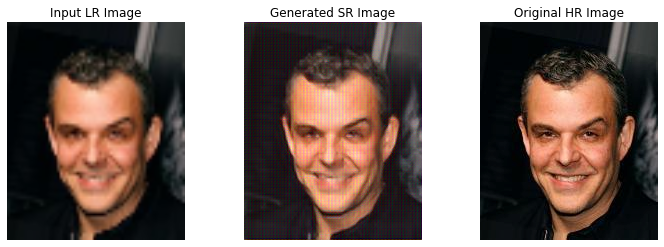

In [16]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130082.jpg')
plot_image(img_lr, img_sr, img_hr)

In [ ]:
type(img_lr)

In [ ]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130082.jpg')
plot_image(img_lr, img_sr, img_hr)

In [ ]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130869.jpg')
plot_image(img_lr, img_sr, img_hr)

In [ ]:
img_lr, img_sr, img_hr = rescale_img('datasets/img_align_celeba/130869.jpg')
plot_image(img_lr, img_sr, img_hr)

In [ ]:
img_sr

In [ ]:
img_sr